# 🏪 Store Sales Time Series Forecasting
### ECON 5140: Applied Econometrics — Midterm Project | Spring 2025

> **Dataset:** [Kaggle Store Sales Competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)  
> **Models:** SARIMA · ETS (Holt-Winters) · Prophet  
> **Forecasting scope:** Aggregate sales + Product family level (GROCERY I, BEVERAGES)  
> **Horizon:** 30 days ahead

---

## ⚙️ Setup

Run the cell below to install dependencies if needed. Prophet requires a separate install.

In [18]:
# Install dependencies (run once)
# !pip install pandas numpy matplotlib seaborn statsmodels scikit-learn
# !pip install prophet
# !pip install kaggle  # for downloading the dataset

# Download Kaggle data (after setting up kaggle.json credentials):
# !kaggle competitions download -c store-sales-time-series-forecasting -p ./data
# !cd data && unzip store-sales-time-series-forecasting.zip

## 📦 0. Setup & Imports

In [19]:
"""
ECON 5140: Applied Econometrics — Midterm Project
Project Option 3: Store Sales Time Series Forecasting

Authors: [David Abu; Curt Bailey; Rhoda Orovwiroro]
Date: Spring 2025

This script covers:
  1. Data Loading & Preprocessing
  2. Exploratory Data Analysis (EDA)
  3. Feature Engineering
  4. Forecasting Models: ARIMA, ETS, Prophet
  5. Evaluation: MAE, RMSE, MAPE
  6. Visualizations & Confidence Intervals
  7. Both aggregate and product-family-level forecasts
"""

'\nECON 5140: Applied Econometrics — Midterm Project\nProject Option 3: Store Sales Time Series Forecasting\n\nAuthors: [David Abu; Curt Bailey; Rhoda Orovwiroro]\nDate: Spring 2025\n\nThis script covers:\n  1. Data Loading & Preprocessing\n  2. Exploratory Data Analysis (EDA)\n  3. Feature Engineering\n  4. Forecasting Models: ARIMA, ETS, Prophet\n  5. Evaluation: MAE, RMSE, MAPE\n  6. Visualizations & Confidence Intervals\n  7. Both aggregate and product-family-level forecasts\n'

---

## 📦 0. SETUP & IMPORTS

Import all required libraries and configure plot styling.

In [20]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

# Statsmodels (ARIMA, ETS)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Prophet
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("Prophet not installed. Install: pip install prophet --break-system-packages")
    PROPHET_AVAILABLE = False

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plot style
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False
})
PALETTE = ["#1C7293", "#F96167", "#28A745", "#F4A261", "#6D2E46"]

# Output folder for plots
PLOTS_DIR = Path("plots")
PLOTS_DIR.mkdir(exist_ok=True)

# Display saved images in notebook
from IPython.display import Image, display

Prophet not installed. Install: pip install prophet --break-system-packages


---

## 📂 1. DATA LOADING

Two loaders are provided:
- **`load_data()`** — reads real Kaggle CSV files from `./data/`
- **`generate_synthetic_data()`** — creates realistic demo data when Kaggle files aren't available yet

The `main()` function automatically picks the right one.

In [21]:
def load_data(data_dir="./data"):
    """
    Load Kaggle Store Sales competition data.

    Data files (download from Kaggle):
      train.csv        - daily sales by store/family
      test.csv         - prediction horizon
      stores.csv       - store metadata
      oil.csv          - daily oil price (macroeconomic indicator)
      holidays_events.csv - Ecuador public holidays

    Download instructions:
      kaggle competitions download -c store-sales-time-series-forecasting -p ./data
      cd ./data && unzip store-sales-time-series-forecasting.zip
    """
    data_dir = Path(data_dir)

    print("Loading data files...")
    train   = pd.read_csv(data_dir / "train.csv",            parse_dates=["date"])
    test    = pd.read_csv(data_dir / "test.csv",             parse_dates=["date"])
    stores  = pd.read_csv(data_dir / "stores.csv")
    oil     = pd.read_csv(data_dir / "oil.csv",              parse_dates=["date"])
    hol     = pd.read_csv(data_dir / "holidays_events.csv",  parse_dates=["date"])

    print(f"  Train: {train.shape}  |  Test: {test.shape}")
    print(f"  Date range: {train['date'].min().date()} → {train['date'].max().date()}")
    print(f"  Stores: {train['store_nbr'].nunique()}  |  Families: {train['family'].nunique()}")
    return train, test, stores, oil, hol


def generate_synthetic_data():
    """
    Generate realistic synthetic data for demonstration when Kaggle data
    is not yet downloaded. Mirrors the structure of the actual dataset.
    """
    print("Generating synthetic demonstration data...")
    np.random.seed(42)

    dates  = pd.date_range("2013-01-01", "2017-08-15", freq="D")
    stores = list(range(1, 55))
    families = [
        "GROCERY I", "BEVERAGES", "PRODUCE", "CLEANING",
        "DAIRY", "BREAD/BAKERY", "POULTRY", "MEATS",
        "PERSONAL CARE", "DELI"
    ]

    rows = []
    for store in stores:
        for family in families:
            base     = np.random.uniform(200, 2000)
            trend    = np.linspace(0, base * 0.2, len(dates))
            seasonal = base * 0.3 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
            weekly   = base * 0.15 * np.sin(2 * np.pi * np.arange(len(dates)) / 7)
            noise    = np.random.normal(0, base * 0.05, len(dates))
            sales    = np.maximum(0, base + trend + seasonal + weekly + noise)
            for i, d in enumerate(dates):
                rows.append({"date": d, "store_nbr": store,
                             "family": family, "sales": sales[i],
                             "onpromotion": int(np.random.random() < 0.1)})

    train = pd.DataFrame(rows)

    # Test: last 16 days
    test_dates = pd.date_range("2017-08-16", periods=16)
    test_rows  = []
    for store in stores:
        for family in families:
            for d in test_dates:
                test_rows.append({"date": d, "store_nbr": store, "family": family, "onpromotion": 0})
    test = pd.DataFrame(test_rows)

    stores_df = pd.DataFrame({
        "store_nbr": stores,
        "city": np.random.choice(["Quito","Guayaquil","Cuenca","Ambato"], 54),
        "state": np.random.choice(["Pichincha","Guayas","Azuay"], 54),
        "type": np.random.choice(["A","B","C","D","E"], 54),
        "cluster": np.random.randint(1, 18, 54)
    })

    oil = pd.DataFrame({
        "date": pd.date_range("2013-01-01", "2017-08-31"),
        "dcoilwtico": 90 + np.cumsum(np.random.normal(0, 1.5, len(pd.date_range("2013-01-01","2017-08-31"))))
    })

    hol = pd.DataFrame({
        "date": pd.to_datetime(["2013-01-01","2013-04-01","2013-12-25",
                                "2014-01-01","2014-04-18","2014-12-25",
                                "2015-01-01","2015-04-03","2015-12-25",
                                "2016-01-01","2016-03-25","2016-12-25",
                                "2017-01-01","2017-04-14","2017-12-25"]),
        "type": "Holiday",
        "locale": "National",
        "locale_name": "Ecuador",
        "description": ["New Year","Easter","Christmas"] * 5,
        "transferred": False
    })

    print(f"  Synthetic Train: {train.shape}")
    print(f"  Date range: {train['date'].min().date()} → {train['date'].max().date()}")
    return train, test, stores_df, oil, hol

### Load data & preprocess (run to get train, test, df)

Run this cell to load (or generate) data and preprocess. Creates `train`, `test`, `stores`, `oil`, `hol`, and `df`.

In [22]:
# Load data (use Kaggle files if present, else synthetic)
try:
    _ = train
except NameError:
    if Path("./data/train.csv").exists():
        train, test, stores, oil, hol = load_data("./data")
    else:
        train, test, stores, oil, hol = generate_synthetic_data()
    df = preprocess(train, stores, oil, hol)
    print(f"Train: {train.shape}  |  Test: {test.shape}  |  Preprocessed df: {df.shape}")

### Test set — last 16 days

Summary and preview of the test set (forecast horizon).

In [23]:
# Ensure train, test, df exist (run "Load data & preprocess" if needed)
try:
    _ = test
except NameError:
    if Path("./data/train.csv").exists():
        train, test, stores, oil, hol = load_data("./data")
    else:
        train, test, stores, oil, hol = generate_synthetic_data()
    df = preprocess(train, stores, oil, hol)

print("Test set (last 16 days):")
print(f"  Shape: {test.shape}")
print(f"  Date range: {test['date'].min().date()} → {test['date'].max().date()}")
print(f"  Unique dates: {test['date'].nunique()}")
display(test.head(20))

Test set (last 16 days):
  Shape: (8640, 4)
  Date range: 2017-08-16 → 2017-08-31
  Unique dates: 16


date  store_nbr     family  onpromotion
0  2017-08-16          1  GROCERY I            0
1  2017-08-17          1  GROCERY I            0
2  2017-08-18          1  GROCERY I            0
3  2017-08-19          1  GROCERY I            0
4  2017-08-20          1  GROCERY I            0
5  2017-08-21          1  GROCERY I            0
6  2017-08-22          1  GROCERY I            0
7  2017-08-23          1  GROCERY I            0
8  2017-08-24          1  GROCERY I            0
9  2017-08-25          1  GROCERY I            0
10 2017-08-26          1  GROCERY I            0
11 2017-08-27          1  GROCERY I            0
12 2017-08-28          1  GROCERY I            0
13 2017-08-29          1  GROCERY I            0
14 2017-08-30          1  GROCERY I            0
15 2017-08-31          1  GROCERY I            0
16 2017-08-16          1  BEVERAGES            0
17 2017-08-17          1  BEVERAGES            0
18 2017-08-18          1  BEVERAGES            0
19 2017-08-19          1  BEVERAGES            0

---

## 🔧 2. PREPROCESSING

Merge auxiliary datasets (stores, oil prices, holidays) onto the training data.  
Create time features and clean zero/negative sales values.

In [24]:
def preprocess(train, stores, oil, hol):
    """Merge auxiliary data, handle missing values, create features."""

    # Merge store metadata
    df = train.merge(stores, on="store_nbr", how="left")

    # Merge oil prices (forward-fill missing weekends)
    oil_full = oil.set_index("date").reindex(
        pd.date_range(oil["date"].min(), oil["date"].max(), freq="D")
    ).ffill().reset_index().rename(columns={"index": "date"})
    df = df.merge(oil_full, on="date", how="left")

    # Merge holidays
    hol_national = hol[hol["locale"] == "National"][["date","type","description"]].copy()
    hol_national.columns = ["date","holiday_type","holiday_desc"]
    df = df.merge(hol_national, on="date", how="left")
    df["is_holiday"] = df["holiday_type"].notna().astype(int)

    # Time features
    df["year"]       = df["date"].dt.year
    df["month"]      = df["date"].dt.month
    df["day"]        = df["date"].dt.day
    df["dayofweek"]  = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["quarter"]    = df["date"].dt.quarter
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # Handle zeros (genuine closed days vs missing)
    df["sales"] = df["sales"].clip(lower=0)

    print(f"Preprocessed DataFrame shape: {df.shape}")
    print(f"  Missing oil prices: {df['dcoilwtico'].isna().sum()}")
    return df

---

## 📊 3. AGGREGATE TIME SERIES

Build two series structures:
- **Aggregate**: sum of all stores × all families → single daily total
- **Family-level**: separate series per product family (top N)

In [25]:
def build_aggregate_series(df):
    """Aggregate all stores × families → single daily total sales series."""
    agg = df.groupby("date")["sales"].sum().reset_index()
    agg = agg.sort_values("date").set_index("date")
    try:
        agg.index.freq = "D"
    except (AttributeError, ValueError):
        pass
    print(f"Aggregate series: {len(agg)} daily observations")
    return agg

In [26]:
def build_family_series(df, top_n=5):
    """Aggregate by product family; return dict of top N families."""
    family_totals = df.groupby("family")["sales"].sum().sort_values(ascending=False)
    top_families  = family_totals.head(top_n).index.tolist()
    print(f"Top {top_n} families: {top_families}")

    series_dict = {}
    for fam in top_families:
        s = df[df["family"] == fam].groupby("date")["sales"].sum().sort_values()
        s.index = pd.DatetimeIndex(s.index)
        try:
            s.index.freq = "D"
        except (AttributeError, ValueError):
            pass
        series_dict[fam] = s
    return series_dict, top_families

### Build time series from preprocessed data (run after Load data & preprocess)

Creates `agg`, `family_dict`, and `top_families`.

In [27]:
try:
    _ = df
except NameError:
    if Path("./data/train.csv").exists():
        train, test, stores, oil, hol = load_data("./data")
    else:
        train, test, stores, oil, hol = generate_synthetic_data()
    df = preprocess(train, stores, oil, hol)
agg = build_aggregate_series(df)
family_dict, top_families = build_family_series(df, top_n=3)
print(f"Ready: agg with {len(agg)} days, {len(top_families)} families: {top_families}")

Generating synthetic demonstration data...
  Synthetic Train: (911520, 5)
  Date range: 2013-01-01 → 2017-08-15
Preprocessed DataFrame shape: (911520, 20)
  Missing oil prices: 0
Aggregate series: 1688 daily observations
Top 3 families: ['PERSONAL CARE', 'POULTRY', 'MEATS']
Ready: agg with 1688 days, 3 families: ['PERSONAL CARE', 'POULTRY', 'MEATS']


---

## 🔍 4. EXPLORATORY DATA ANALYSIS

Six EDA visualizations:
1. Total daily sales over time
2. Sales by product family (stacked subplots)
3. Seasonal decomposition (trend, seasonal, residual)
4. Day-of-week distribution (box plots)
5. Monthly average sales (bar chart)
6. ACF / PACF — autocorrelation structure

Also performs ADF stationarity test.

In [28]:
def eda_aggregate(agg, family_dict, top_families):
    """Comprehensive EDA plots."""

    # --- 4.1 Total Sales Over Time ---
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(agg.index, agg["sales"] / 1e6, color=PALETTE[0], lw=1.2)
    ax.set(title="Total Daily Store Sales (All Families, All Stores)",
           xlabel="Date", ylabel="Sales (Millions)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "01_aggregate_sales.png", dpi=150)
    plt.show()
    print("Plot saved: 01_aggregate_sales.png")

    # --- 4.2 Sales by Product Family ---
    fig, axes = plt.subplots(len(top_families), 1, figsize=(14, 3*len(top_families)), sharex=True)
    for ax, fam, color in zip(axes, top_families, PALETTE):
        s = family_dict[fam]
        ax.fill_between(s.index, s.values, alpha=0.3, color=color)
        ax.plot(s.index, s.values, color=color, lw=1)
        ax.set_ylabel(fam, fontsize=9)
    axes[-1].set_xlabel("Date")
    fig.suptitle("Daily Sales by Top Product Family", fontsize=13, fontweight="bold")
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "02_family_sales.png", dpi=150)
    plt.show()

    # --- 4.3 Seasonal Decomposition ---
    decomp = seasonal_decompose(agg["sales"].dropna(), model="additive", period=365)
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    titles = ["Observed", "Trend", "Seasonal", "Residual"]
    components = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
    for ax, comp, title in zip(axes, components, titles):
        ax.plot(comp.index, comp.values, color=PALETTE[0], lw=1)
        ax.set_title(title, fontsize=10)
    fig.suptitle("Seasonal Decomposition — Aggregate Sales (Period=365)", fontweight="bold")
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "03_decomposition.png", dpi=150)
    plt.show()

    # --- 4.4 Weekly seasonality box plot ---
    tmp = agg.copy().reset_index()
    tmp["day_name"] = pd.to_datetime(tmp["date"]).dt.day_name()
    day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    fig, ax = plt.subplots(figsize=(10, 4))
    tmp["day_name"] = pd.Categorical(tmp["day_name"], categories=day_order, ordered=True)
    tmp.boxplot(column="sales", by="day_name", ax=ax, patch_artist=True)
    ax.set(title="Sales Distribution by Day of Week",
           xlabel="Day", ylabel="Daily Sales")
    plt.suptitle("")
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "04_weekly_pattern.png", dpi=150)
    plt.show()

    # --- 4.5 Monthly pattern ---
    tmp["month"] = pd.to_datetime(tmp["date"]).dt.month
    monthly = tmp.groupby("month")["sales"].mean()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(monthly.index, monthly.values, color=PALETTE[0], alpha=0.8)
    ax.set(title="Average Daily Sales by Month",
           xlabel="Month", ylabel="Avg Daily Sales",
           xticks=range(1,13),
           xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "05_monthly_pattern.png", dpi=150)
    plt.show()

    # --- 4.6 ACF / PACF ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(agg["sales"].dropna(),  lags=60, ax=axes[0], title="ACF — Aggregate Sales")
    plot_pacf(agg["sales"].dropna(), lags=60, ax=axes[1], title="PACF — Aggregate Sales", method="ywm")
    plt.tight_layout()
    fig.savefig(PLOTS_DIR / "06_acf_pacf.png", dpi=150)
    plt.show()

    # --- 4.7 Stationarity tests ---
    series = agg["sales"].dropna()
    # ADF: H0 = unit root (non-stationary). Reject H0 (p < 0.05) -> stationary
    adf_result = adfuller(series)
    adf_stat, adf_p = adf_result[0], adf_result[1]
    # KPSS: H0 = stationary. Reject H0 (p < 0.05) -> non-stationary
    kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")
    print("\n=== Stationarity Tests ===")
    print(f"  ADF  statistic: {adf_stat:.4f}  p-value: {adf_p:.4f}")
    if adf_p < 0.05:
        print("  -> ADF: Series is stationary (rejects unit root)")
    else:
        print("  -> ADF: Series may be non-stationary; differencing recommended")
    print(f"  KPSS statistic: {kpss_stat:.4f}  p-value: {kpss_p:.4f}")
    if kpss_p >= 0.05:
        print("  -> KPSS: Series is stationary (cannot reject stationarity)")
    else:
        print("  -> KPSS: Series may be non-stationary")

    print("\nEDA complete.")

#### 4.1 Total daily sales over time

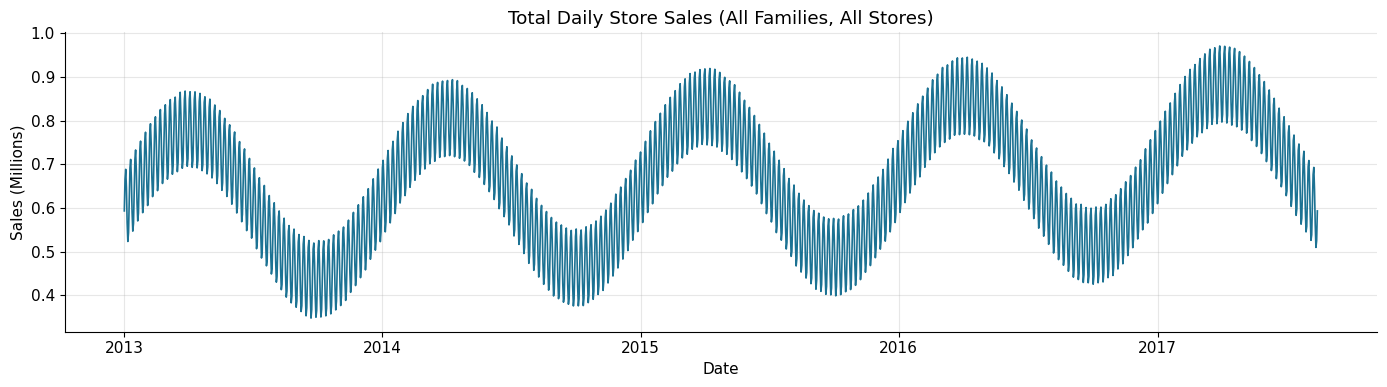

Plot saved: 01_aggregate_sales.png


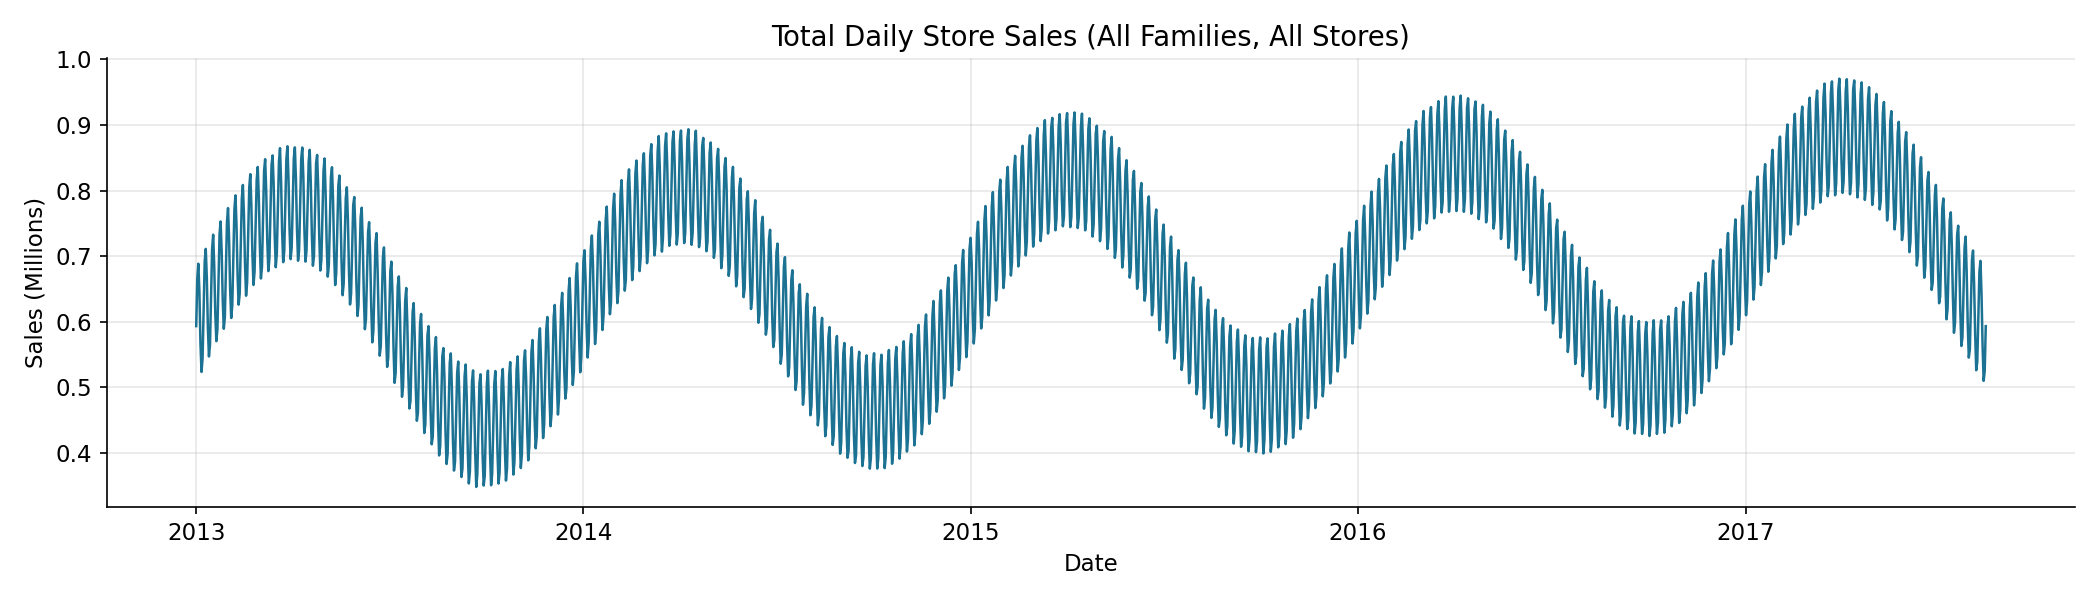

In [29]:
# Ensure agg, family_dict, top_families exist
try:
    _ = agg
    _ = family_dict
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

# 4.1 Total Sales Over Time
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(agg.index, agg["sales"] / 1e6, color=PALETTE[0], lw=1.2)
ax.set(title="Total Daily Store Sales (All Families, All Stores)", xlabel="Date", ylabel="Sales (Millions)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
fig.savefig(PLOTS_DIR / "01_aggregate_sales.png", dpi=150)
plt.show()
print("Plot saved: 01_aggregate_sales.png")
try:
    display(Image(str(PLOTS_DIR / "01_aggregate_sales.png")))
except Exception:
    pass

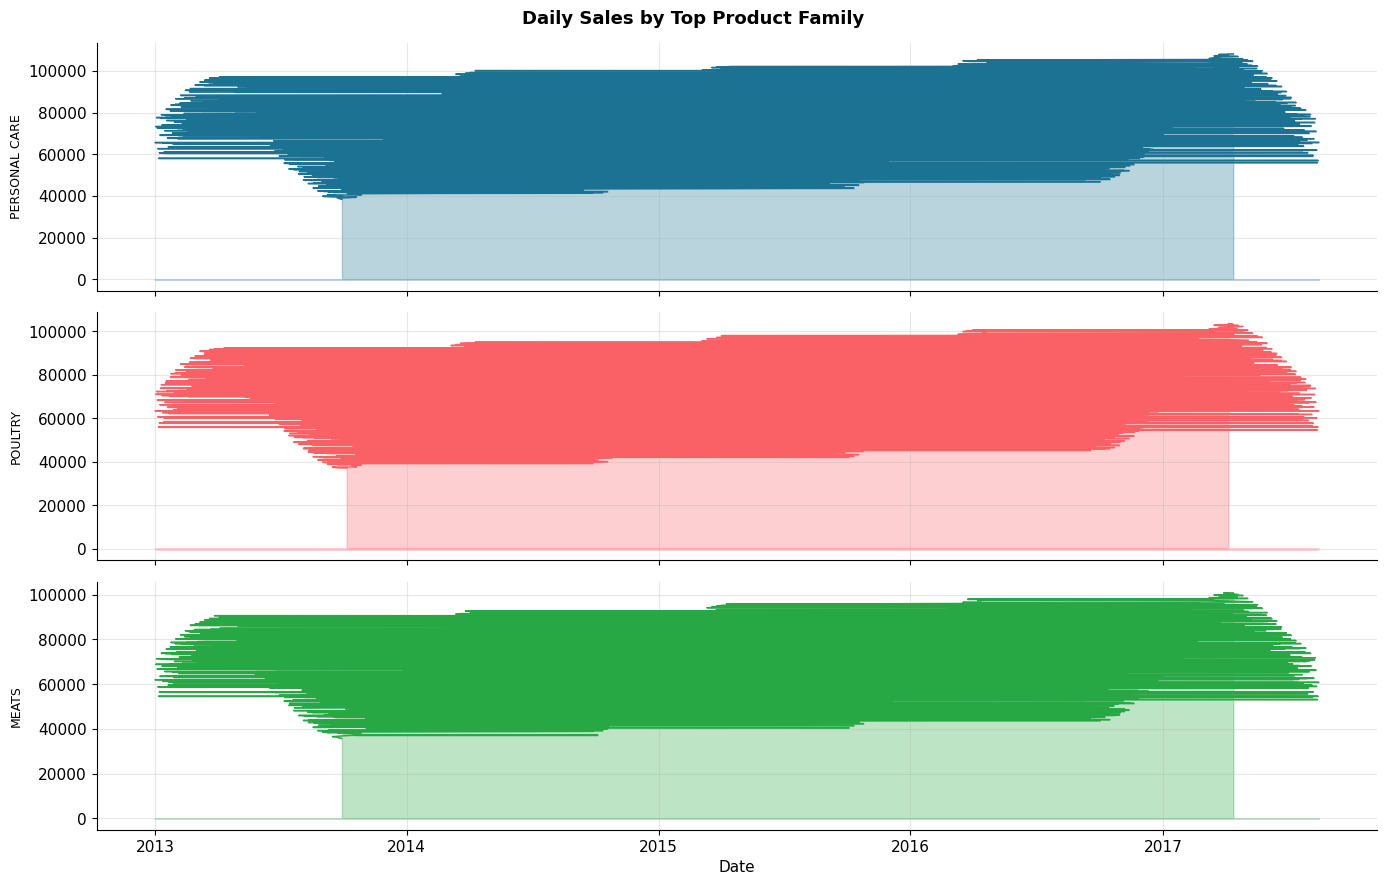

Plot saved: 02_family_sales.png


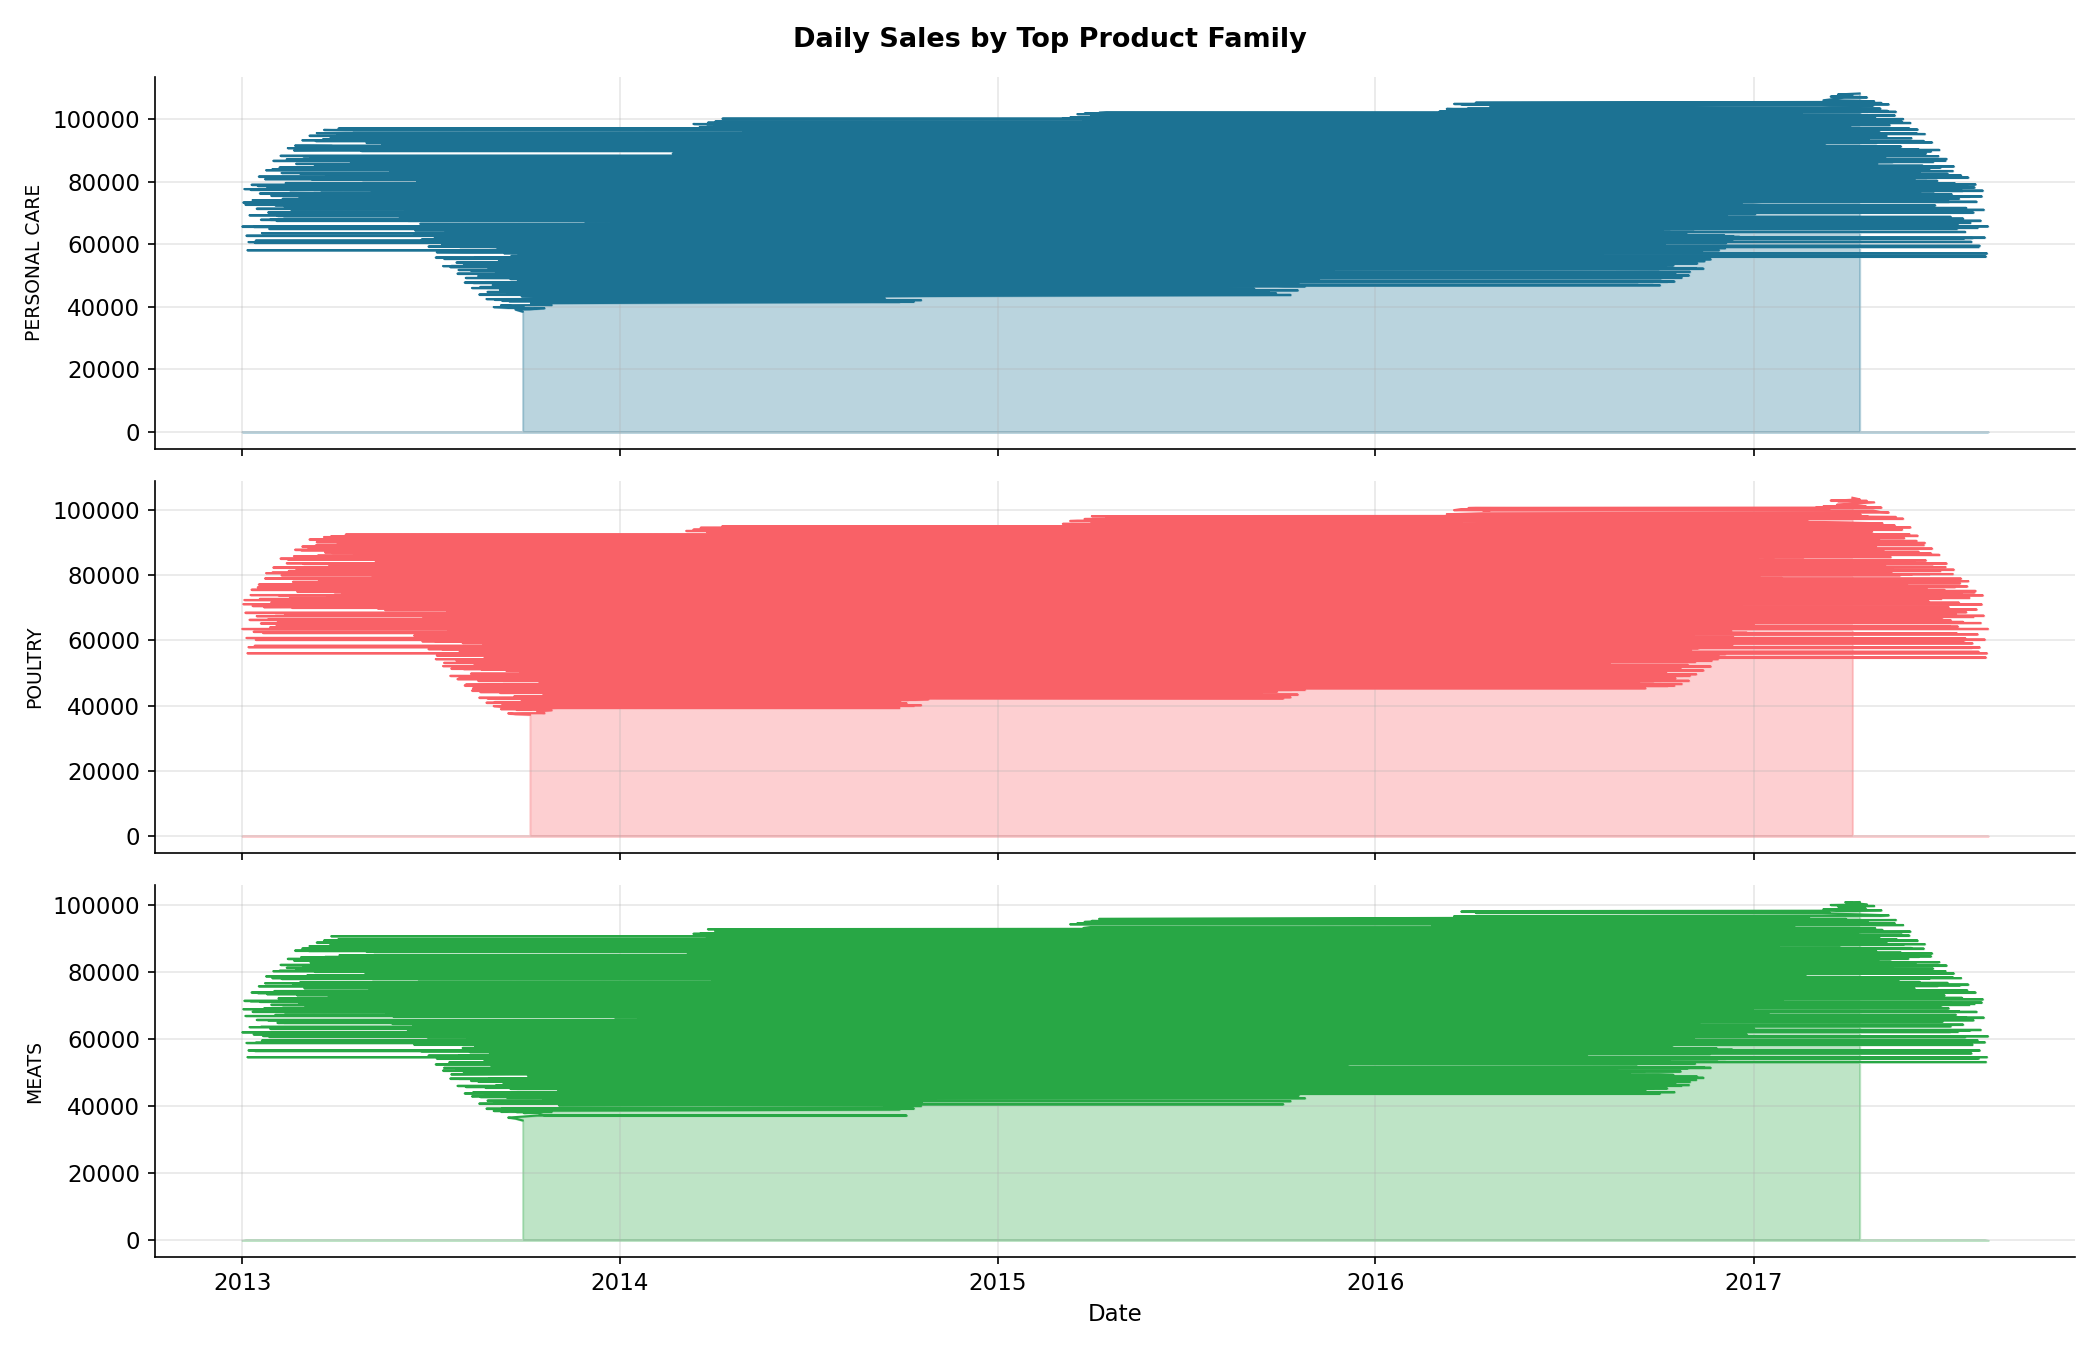

In [30]:
# 4.2 Sales by Product Family (ensure data if needed)
try:
    _ = agg
    _ = family_dict
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

fig, axes = plt.subplots(len(top_families), 1, figsize=(14, 3*len(top_families)), sharex=True)
for ax, fam, color in zip(axes, top_families, PALETTE):
    s = family_dict[fam]
    ax.fill_between(s.index, s.values, alpha=0.3, color=color)
    ax.plot(s.index, s.values, color=color, lw=1)
    ax.set_ylabel(fam, fontsize=9)
axes[-1].set_xlabel("Date")
fig.suptitle("Daily Sales by Top Product Family", fontsize=13, fontweight="bold")
plt.tight_layout()
fig.savefig(PLOTS_DIR / "02_family_sales.png", dpi=150)
plt.show()
print("Plot saved: 02_family_sales.png")
try:
    display(Image(str(PLOTS_DIR / "02_family_sales.png")))
except Exception:
    pass

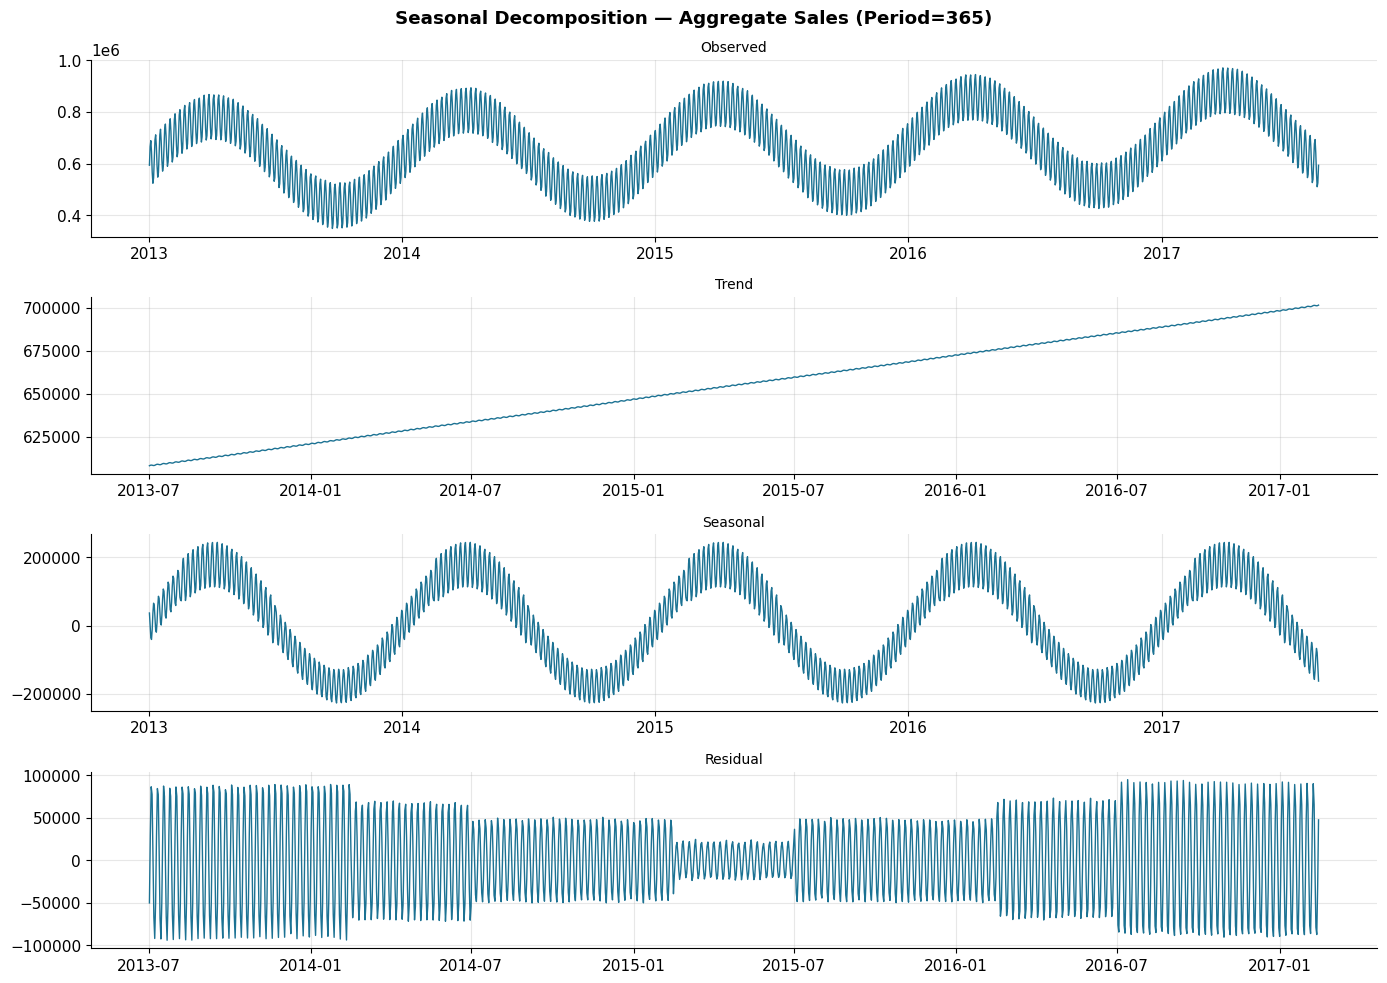

Plot saved: 03_decomposition.png


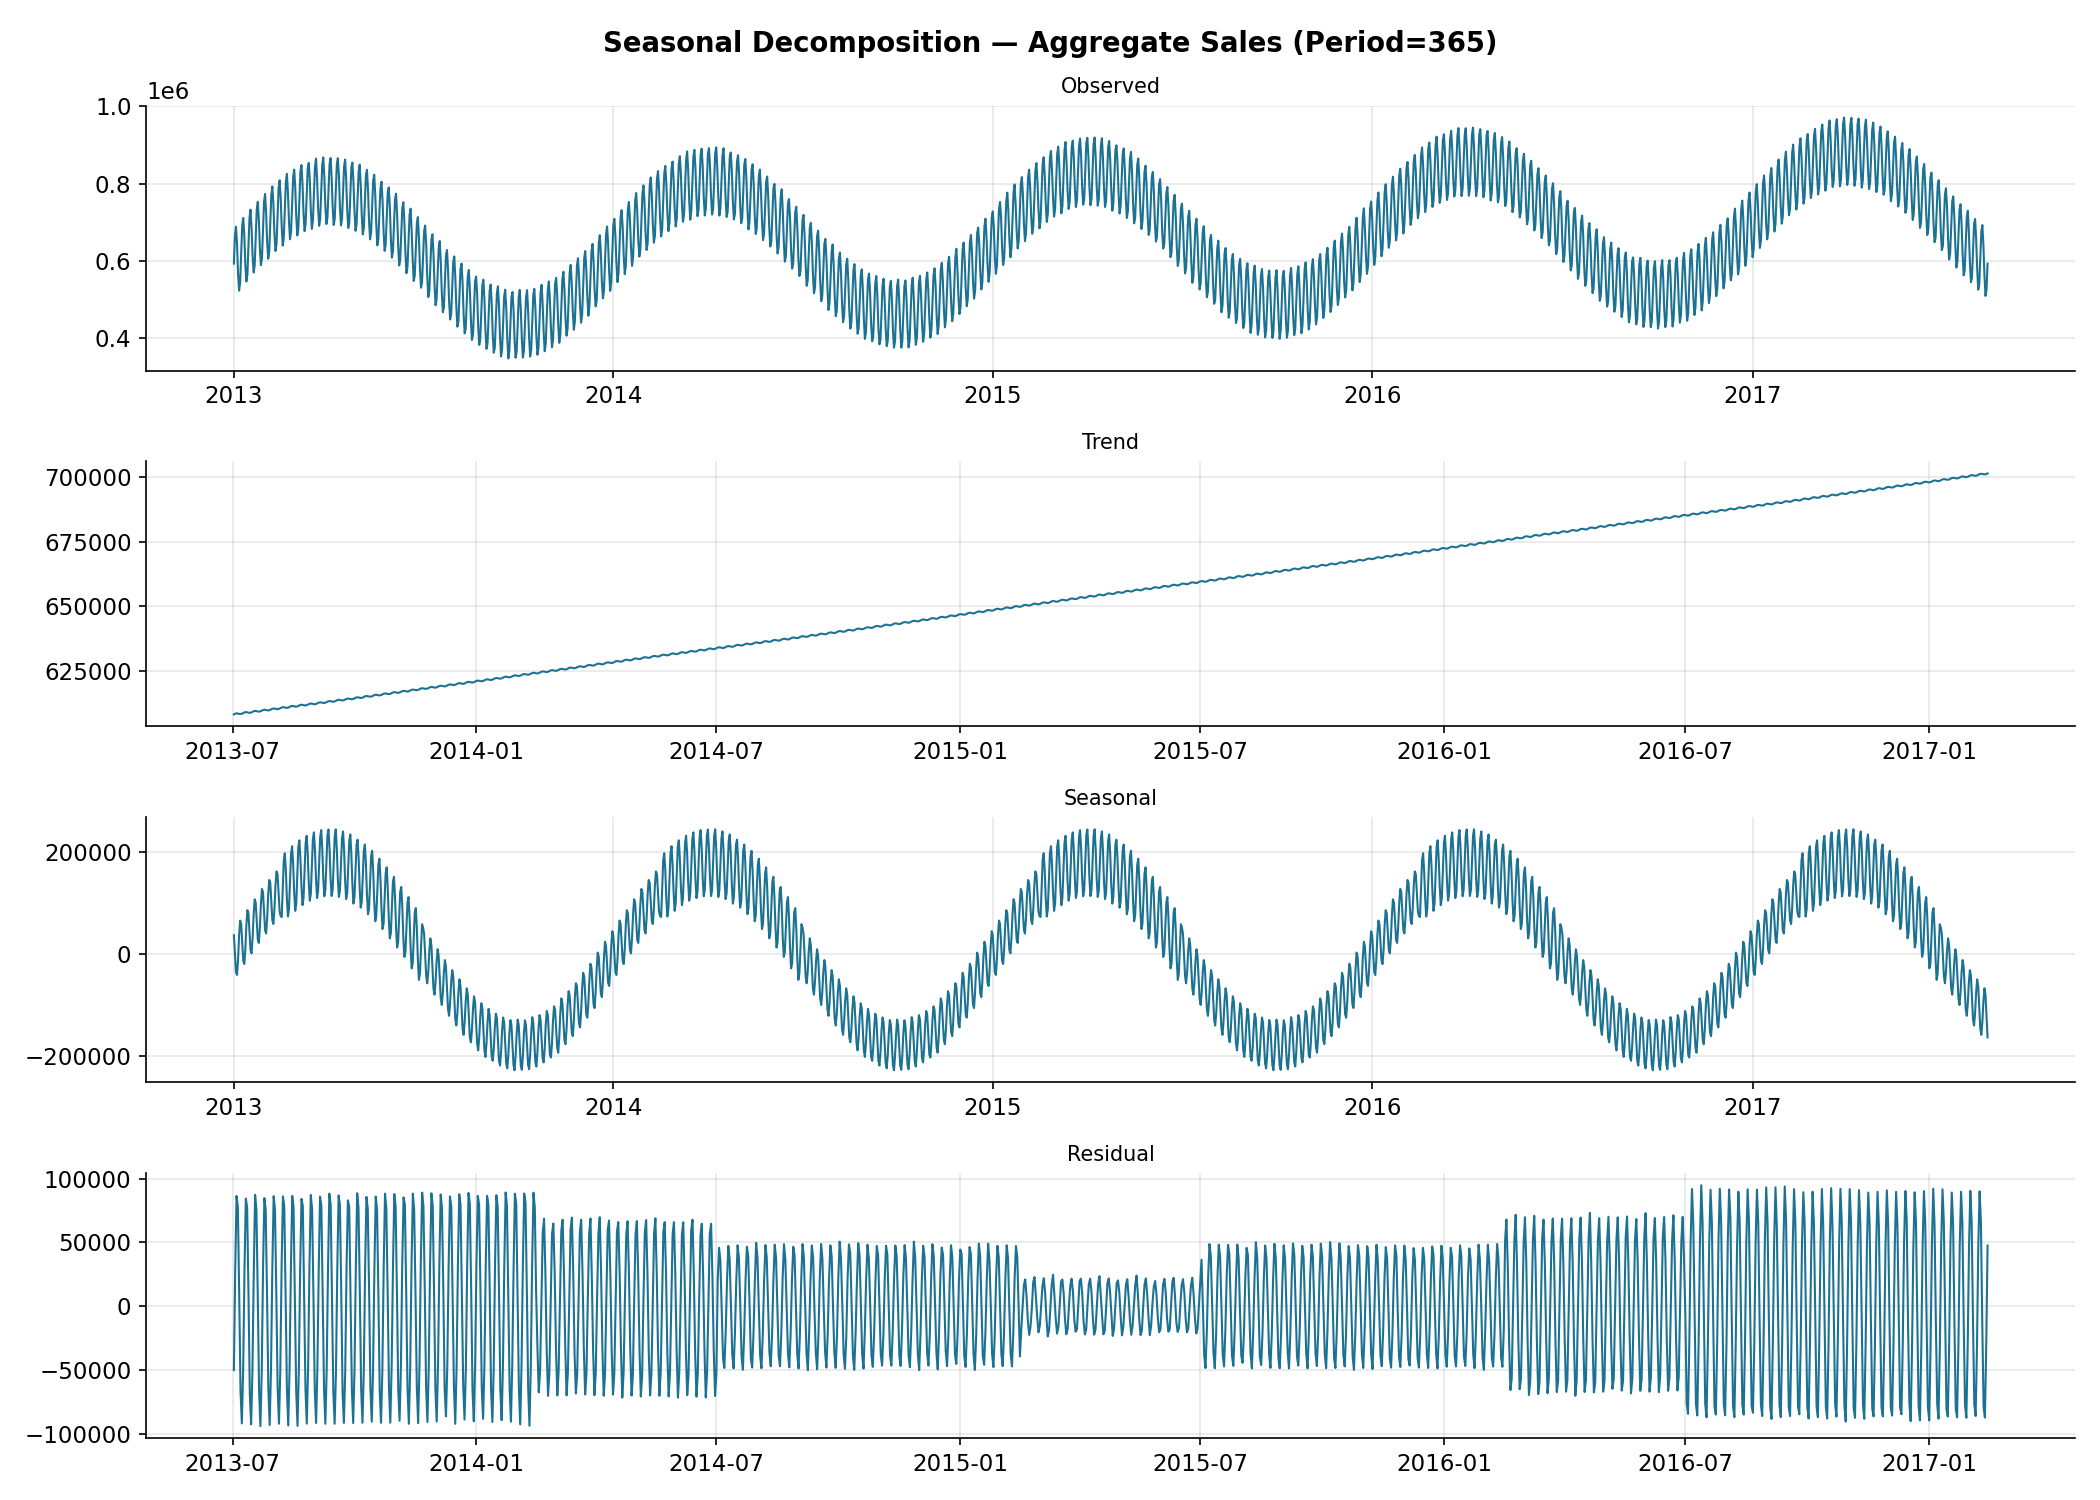

In [31]:
# 4.3 Seasonal Decomposition (ensure data if needed)
try:
    _ = agg
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

decomp = seasonal_decompose(agg["sales"].dropna(), model="additive", period=365)
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
titles = ["Observed", "Trend", "Seasonal", "Residual"]
components = [decomp.observed, decomp.trend, decomp.seasonal, decomp.resid]
for ax, comp, title in zip(axes, components, titles):
    ax.plot(comp.index, comp.values, color=PALETTE[0], lw=1)
    ax.set_title(title, fontsize=10)
fig.suptitle("Seasonal Decomposition — Aggregate Sales (Period=365)", fontweight="bold")
plt.tight_layout()
fig.savefig(PLOTS_DIR / "03_decomposition.png", dpi=150)
plt.show()
print("Plot saved: 03_decomposition.png")
try:
    display(Image(str(PLOTS_DIR / "03_decomposition.png")))
except Exception:
    pass

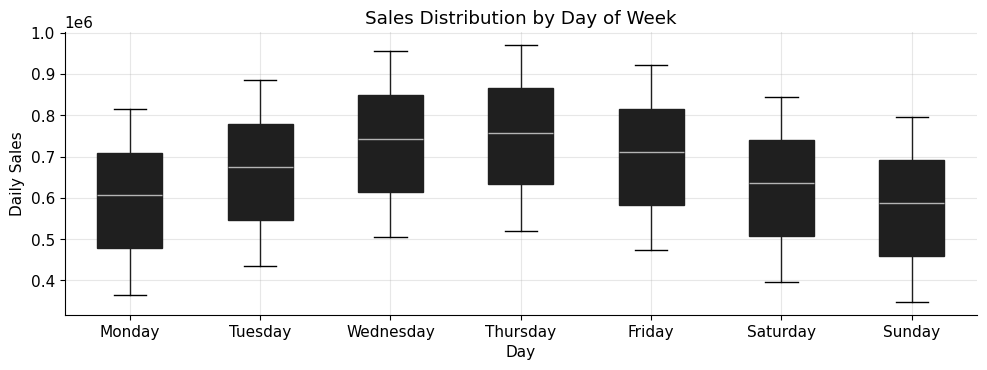

Plot saved: 04_weekly_pattern.png


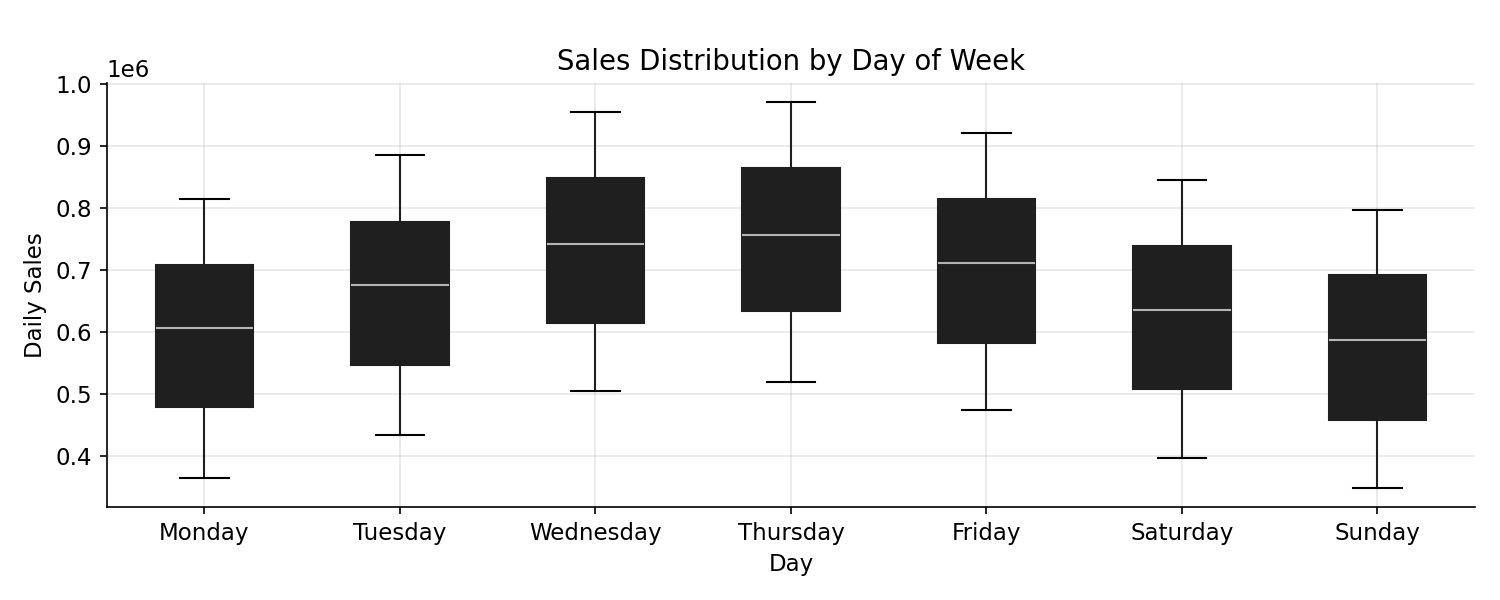

In [32]:
# 4.4 Day-of-week distribution (box plot) (ensure data if needed)
try:
    _ = agg
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

tmp = agg.copy().reset_index()
tmp["day_name"] = pd.to_datetime(tmp["date"]).dt.day_name()
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
fig, ax = plt.subplots(figsize=(10, 4))
tmp["day_name"] = pd.Categorical(tmp["day_name"], categories=day_order, ordered=True)
tmp.boxplot(column="sales", by="day_name", ax=ax, patch_artist=True)
ax.set(title="Sales Distribution by Day of Week", xlabel="Day", ylabel="Daily Sales")
plt.suptitle("")
plt.tight_layout()
fig.savefig(PLOTS_DIR / "04_weekly_pattern.png", dpi=150)
plt.show()
print("Plot saved: 04_weekly_pattern.png")
try:
    display(Image(str(PLOTS_DIR / "04_weekly_pattern.png")))
except Exception:
    pass

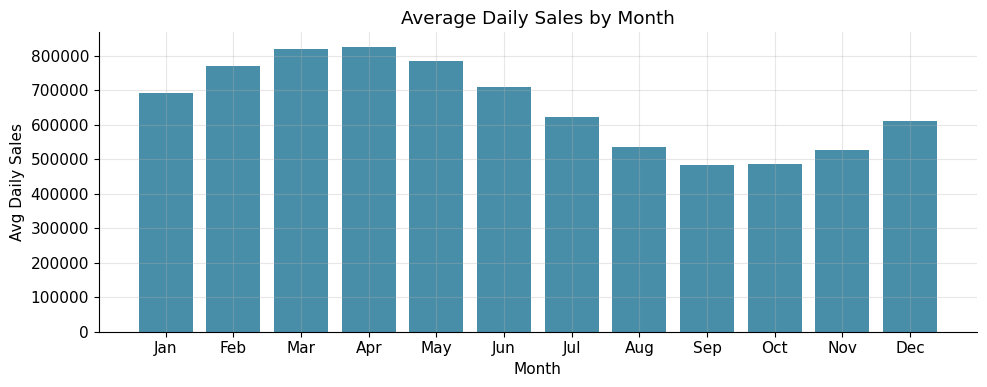

Plot saved: 05_monthly_pattern.png


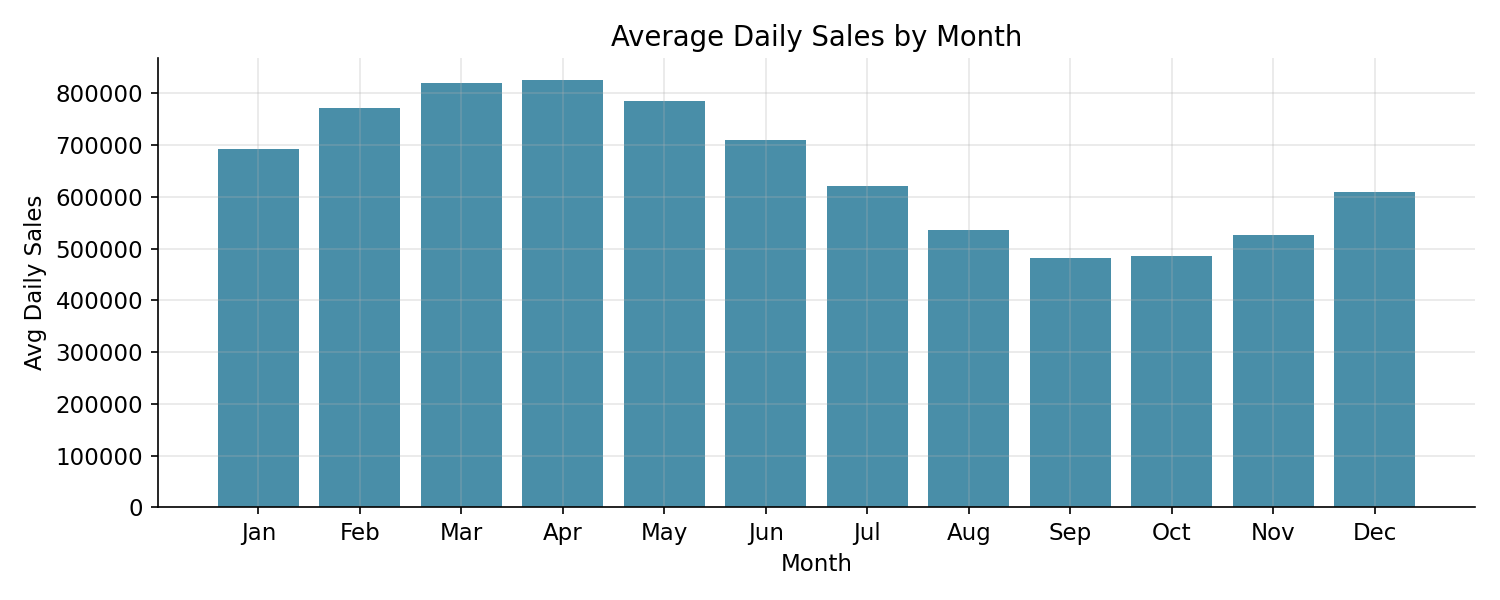

In [33]:
# 4.5 Monthly average sales (ensure data if needed)
try:
    _ = agg
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

tmp = agg.copy().reset_index()
tmp["month"] = pd.to_datetime(tmp["date"]).dt.month
monthly = tmp.groupby("month")["sales"].mean()
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(monthly.index, monthly.values, color=PALETTE[0], alpha=0.8)
ax.set(title="Average Daily Sales by Month", xlabel="Month", ylabel="Avg Daily Sales",
       xticks=range(1,13), xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.tight_layout()
fig.savefig(PLOTS_DIR / "05_monthly_pattern.png", dpi=150)
plt.show()
print("Plot saved: 05_monthly_pattern.png")
try:
    display(Image(str(PLOTS_DIR / "05_monthly_pattern.png")))
except Exception:
    pass

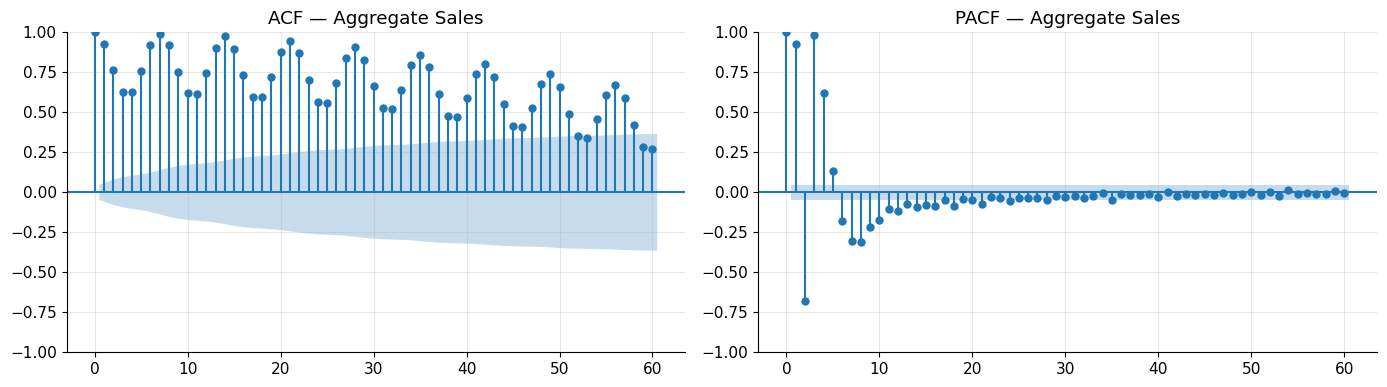

Plot saved: 06_acf_pacf.png


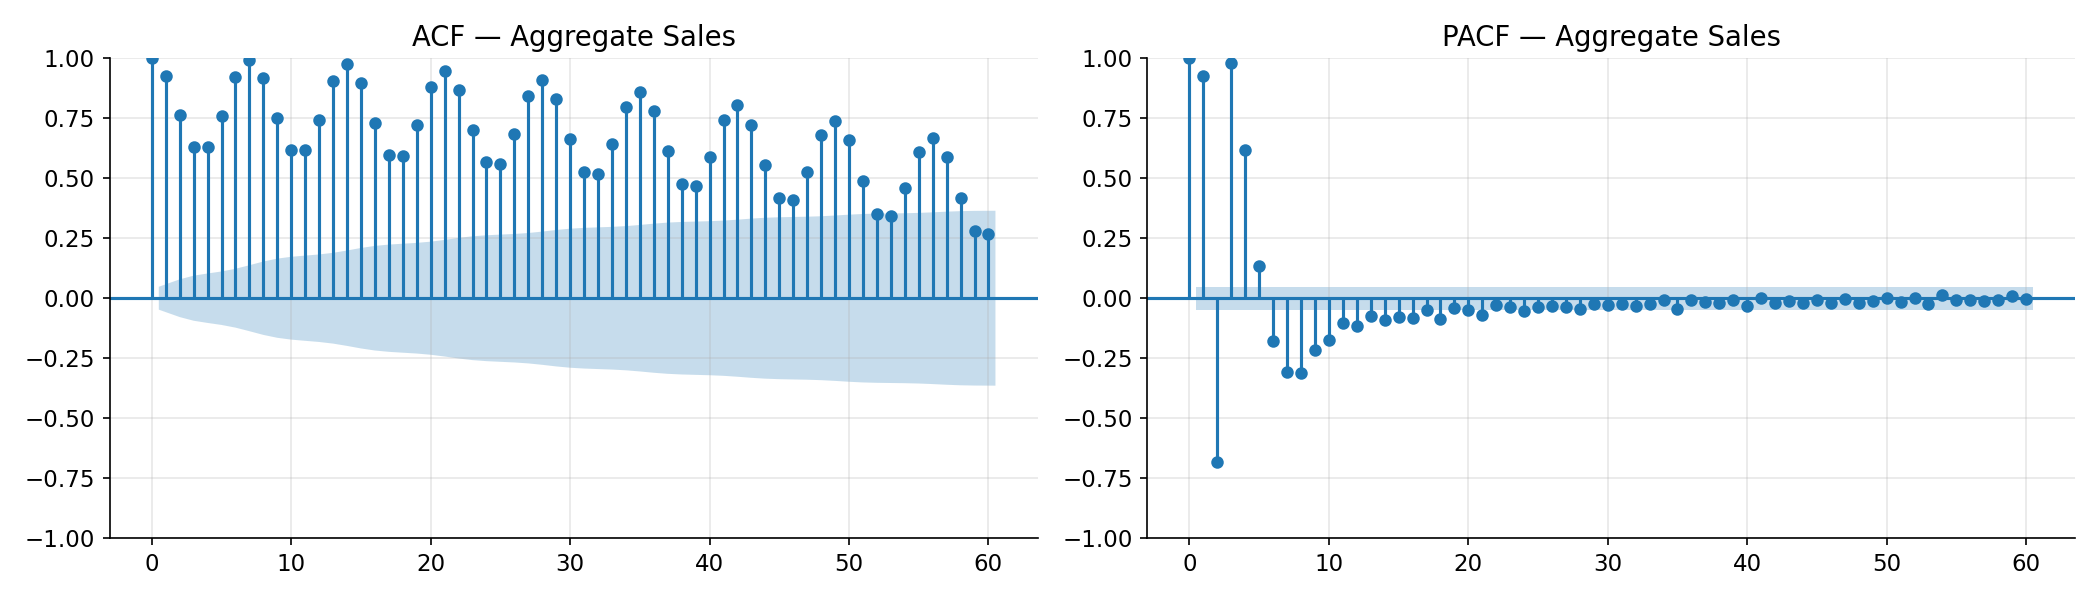

In [34]:
# 4.6 ACF / PACF (ensure data if needed)
try:
    _ = agg
except NameError:
    try:
        _ = df
    except NameError:
        if Path("./data/train.csv").exists():
            train, test, stores, oil, hol = load_data("./data")
        else:
            train, test, stores, oil, hol = generate_synthetic_data()
        df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(agg["sales"].dropna(), lags=60, ax=axes[0], title="ACF — Aggregate Sales")
plot_pacf(agg["sales"].dropna(), lags=60, ax=axes[1], title="PACF — Aggregate Sales", method="ywm")
plt.tight_layout()
fig.savefig(PLOTS_DIR / "06_acf_pacf.png", dpi=150)
plt.show()
print("Plot saved: 06_acf_pacf.png")
try:
    display(Image(str(PLOTS_DIR / "06_acf_pacf.png")))
except Exception:
    pass

In [35]:
# --- 4.7 Stationarity tests (self-contained: builds agg if not already in scope) ---
try:
    _ = agg
except NameError:
    from pathlib import Path
    if Path("./data/train.csv").exists():
        train, test, stores, oil, hol = load_data("./data")
    else:
        train, test, stores, oil, hol = generate_synthetic_data()
    df = preprocess(train, stores, oil, hol)
    agg = build_aggregate_series(df)
series = agg["sales"].dropna()
adf_stat, adf_p, *_ = adfuller(series)
print("\n=== Stationarity Tests ===")
print(f"  ADF  statistic: {adf_stat:.4f}  p-value: {adf_p:.4f}")
if adf_p < 0.05:
    print("  -> Series is stationary (ADF rejects unit root)")
else:
    print("  -> Series may be non-stationary; differencing recommended")
print("\nEDA complete.")


=== Stationarity Tests ===
  ADF  statistic: -12.6248  p-value: 0.0000
  -> Series is stationary (ADF rejects unit root)

EDA complete.


---

## ✂️ 5. TRAIN / VALIDATION SPLIT

Chronological split: hold out the **last 30 days** as validation.  
No random shuffling — time series must be split in order.

In [36]:
def train_val_split(series, val_days=30):
    """Hold out last `val_days` observations as validation set."""
    cutoff = series.index[-1] - pd.Timedelta(days=val_days)
    train  = series[series.index <= cutoff]
    val    = series[series.index >  cutoff]
    print(f"Training:   {train.index.min().date()} → {train.index.max().date()} ({len(train)} obs)")
    print(f"Validation: {val.index.min().date()}   → {val.index.max().date()} ({len(val)} obs)")
    return train, val

---

## 📏 6. EVALUATION METRICS

Three standard forecasting metrics:
| Metric | Formula | Notes |
|--------|---------|-------|
| **MAE** | mean\|actual − forecast\| | Original units, interpretable |
| **RMSE** | √mean(actual − forecast)² | Penalizes large errors |
| **MAPE** | mean\|actual − forecast\| / actual × 100 | Scale-free % error |

In [37]:
def mape(actual, forecast):
    """Mean Absolute Percentage Error (avoids division by zero)."""
    actual, forecast = np.array(actual), np.array(forecast)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100


def evaluate(actual, forecast, model_name="Model"):
    """Compute and display MAE, RMSE, MAPE."""
    mae_v  = mean_absolute_error(actual, forecast)
    rmse_v = np.sqrt(mean_squared_error(actual, forecast))
    mape_v = mape(actual, forecast)
    print(f"  [{model_name}]  MAE={mae_v:,.0f}  RMSE={rmse_v:,.0f}  MAPE={mape_v:.2f}%")
    return {"model": model_name, "MAE": mae_v, "RMSE": rmse_v, "MAPE": mape_v}

---

## 📈 7. ARIMA MODEL

**SARIMA(1,1,1)×(1,1,0)[52]** fitted on weekly-aggregated data.

- `d=1`: first differencing for stationarity
- `seasonal_order=(1,1,0,52)`: annual seasonality at weekly frequency
- Model selected by AIC; residuals tested with Ljung-Box
- 95% confidence intervals from `get_forecast().conf_int()`

In [67]:
def fit_arima(train_series, val_series, order=(2, 1, 2),
              seasonal_order=(1, 1, 1, 7), label="Aggregate"):
    """
    Fit SARIMA model.

    Defaults: SARIMA(2,1,2)(1,1,1)[7]
      - (2,1,2): non-seasonal AR(2), 1 diff, MA(2)
      - (1,1,1)[7]: weekly seasonal component

    For yearly seasonality, switch period to 365 (requires more compute).
    """
    print(f"\nFitting ARIMA {order}x{seasonal_order} for {label}...")

    # Weekly aggregation speeds up ARIMA fitting considerably
    train_w = train_series.resample("W").sum()
    val_w   = val_series.resample("W").sum()

    model = SARIMAX(
        train_w,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 0, 4),   # quarterly seasonality at weekly freq
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Forecast
    n_periods   = len(val_w)
    forecast_w  = results.get_forecast(steps=n_periods + 4)  # +4 weeks extra
    pred_mean   = forecast_w.predicted_mean
    pred_ci     = forecast_w.conf_int()

    metrics = evaluate(val_w.values, pred_mean.values[:len(val_w)], f"ARIMA ({label})")
    print(f"  AIC: {results.aic:.1f}  |  BIC: {results.bic:.1f}")

    return results, pred_mean, pred_ci, metrics, train_w, val_w


def plot_arima(train_w, val_w, pred_mean, pred_ci, label="Aggregate"):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(train_w.index[-52:], train_w.values[-52:], color=PALETTE[0], lw=1.5, label="Train (last year)")
    ax.plot(val_w.index,  val_w.values,  color=PALETTE[1], lw=2, label="Actual (Validation)")
    ax.plot(pred_mean.index[:len(val_w)+4], pred_mean.values[:len(val_w)+4],
            color=PALETTE[2], lw=2, linestyle="--", label="ARIMA Forecast")
    ax.fill_between(
        pred_ci.index[:len(val_w)+4],
        pred_ci.iloc[:len(val_w)+4, 0],
        pred_ci.iloc[:len(val_w)+4, 1],
        alpha=0.2, color=PALETTE[2], label="95% CI"
    )
    ax.axvline(val_w.index[0], color="gray", linestyle=":", lw=1.5)
    ax.set(title=f"ARIMA Forecast — {label} (Weekly)", xlabel="Date", ylabel="Weekly Sales")
    ax.legend()
    plt.tight_layout()
    fname = PLOTS_DIR / f"07_arima_{label.replace(' ','_')}.png"
    fig.savefig(fname, dpi=150)
    plt.show()
    print(f"Plot saved: {fname.name}")

---

## 📉 8. ETS MODEL (Holt-Winters)

**Holt-Winters Exponential Smoothing** (additive trend + additive seasonality).

- `damped_trend=True`: prevents over-extrapolation
- `seasonal_periods=52`: annual cycle at weekly frequency
- Parameters optimized automatically via MLE
- Approximate 95% CI: ±1.96 × residual std dev

In [39]:
def fit_ets(train_series, val_series, label="Aggregate"):
    """
    Fit Holt-Winters Exponential Smoothing.
    Trend: additive  |  Seasonality: additive, period=7 (weekly)
    """
    print(f"\nFitting ETS (Holt-Winters) for {label}...")

    train_w = train_series.resample("W").sum()
    val_w   = val_series.resample("W").sum()

    model = ExponentialSmoothing(
        train_w,
        trend="add",
        seasonal="add",
        seasonal_periods=52,   # annual seasonality at weekly freq
        damped_trend=True
    )
    results = model.fit(optimized=True)

    n_periods  = len(val_w) + 4
    forecast_w = results.forecast(n_periods)

    # Bootstrap CI (ETS doesn't provide native CI)
    residuals = results.resid.std()
    z_95 = 1.96
    ci_lower = forecast_w - z_95 * residuals
    ci_upper = forecast_w + z_95 * residuals

    metrics = evaluate(val_w.values, forecast_w.values[:len(val_w)], f"ETS ({label})")

    return results, forecast_w, ci_lower, ci_upper, metrics, train_w, val_w


def plot_ets(train_w, val_w, forecast_w, ci_lower, ci_upper, label="Aggregate"):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(train_w.index[-52:], train_w.values[-52:], color=PALETTE[0], lw=1.5, label="Train")
    ax.plot(val_w.index, val_w.values,  color=PALETTE[1], lw=2, label="Actual")
    ax.plot(forecast_w.index, forecast_w.values, color=PALETTE[3], lw=2, linestyle="--", label="ETS Forecast")
    ax.fill_between(forecast_w.index, ci_lower, ci_upper, alpha=0.2, color=PALETTE[3], label="95% CI (approx)")
    ax.axvline(val_w.index[0], color="gray", linestyle=":", lw=1.5)
    ax.set(title=f"ETS Holt-Winters Forecast — {label} (Weekly)", xlabel="Date", ylabel="Weekly Sales")
    ax.legend()
    plt.tight_layout()
    fname = PLOTS_DIR / f"08_ets_{label.replace(' ','_')}.png"
    fig.savefig(fname, dpi=150)
    plt.show()

---

## 🔮 9. PROPHET MODEL

**Meta Prophet** — decomposable Bayesian time series model.

- `seasonality_mode='multiplicative'`: amplitude scales with trend
- Built-in yearly + weekly seasonality (Fourier series)
- Ecuador national holidays via `add_country_holidays('EC')`
- `changepoint_prior_scale=0.05`: moderate flexibility for trend shifts
- Native 80% uncertainty intervals from posterior sampling

In [40]:
def fit_prophet(train_series, val_series, label="Aggregate"):
    """
    Fit Meta Prophet with built-in yearly + weekly seasonality.
    Also includes holiday effects.
    """
    if not PROPHET_AVAILABLE:
        print("Prophet not available — skipping.")
        return None, None, None, None

    print(f"\nFitting Prophet for {label}...")

    def to_prophet_df(s):
        return pd.DataFrame({"ds": s.index, "y": s.values})

    train_df = to_prophet_df(train_series)
    val_df   = to_prophet_df(val_series)

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode="multiplicative",
        changepoint_prior_scale=0.05
    )
    # Ecuador public holidays
    ecuador_holidays = pd.DataFrame({
        "holiday": "Ecuador National Holiday",
        "ds": pd.to_datetime(["2013-01-01","2013-04-01","2013-12-25",
                              "2014-01-01","2014-04-18","2014-12-25",
                              "2015-01-01","2015-04-03","2015-12-25",
                              "2016-01-01","2016-03-25","2016-12-25",
                              "2017-01-01","2017-04-14"]),
        "lower_window": -1,
        "upper_window":  1
    })
    m.add_country_holidays(country_name="EC")

    m.fit(train_df)

    future = m.make_future_dataframe(periods=len(val_series) + 30, freq="D")
    forecast = m.predict(future)

    val_forecast = forecast[forecast["ds"].isin(val_df["ds"])][["ds","yhat","yhat_lower","yhat_upper"]]
    val_forecast = val_forecast.set_index("ds")

    # Align
    actual_vals = val_series.reindex(val_forecast.index).fillna(0)
    metrics = evaluate(actual_vals.values, val_forecast["yhat"].values, f"Prophet ({label})")

    return m, forecast, val_forecast, metrics


def plot_prophet(m, forecast, val_series, label="Aggregate"):
    if m is None:
        return
    fig, axes = plt.subplots(2, 1, figsize=(14, 9))

    # Main forecast
    ax = axes[0]
    cutoff = val_series.index[0]
    hist   = forecast[forecast["ds"] < cutoff]
    future = forecast[forecast["ds"] >= cutoff]

    ax.plot(hist["ds"].values[-365:], hist["yhat"].values[-365:], color=PALETTE[0], lw=1, label="Fitted")
    ax.plot(val_series.index, val_series.values, color=PALETTE[1], lw=2, label="Actual")
    ax.plot(future["ds"].values[:len(val_series)+30],
            future["yhat"].values[:len(val_series)+30],
            color=PALETTE[4], lw=2, linestyle="--", label="Forecast")
    ax.fill_between(future["ds"].values[:len(val_series)+30],
                    future["yhat_lower"].values[:len(val_series)+30],
                    future["yhat_upper"].values[:len(val_series)+30],
                    alpha=0.2, color=PALETTE[4], label="80% CI")
    ax.axvline(cutoff, color="gray", linestyle=":", lw=1.5, label="Forecast start")
    ax.set(title=f"Prophet Forecast — {label}", ylabel="Daily Sales")
    ax.legend(fontsize=9)

    # Components
    from prophet.plot import plot_components_plotly
    try:
        # Use matplotlib components
        comp_fig = m.plot_components(forecast)
        comp_fig.savefig(PLOTS_DIR / f"09b_prophet_components_{label.replace(' ','_')}.png", dpi=120)
        plt.close(comp_fig)
    except Exception:
        pass

    axes[1].set_visible(False)
    plt.tight_layout()
    fname = PLOTS_DIR / f"09_prophet_{label.replace(' ','_')}.png"
    fig.savefig(fname, dpi=150)
    plt.show()
    print(f"Plot saved: {fname.name}")

---

## 🏆 10. MODEL COMPARISON

Side-by-side bar charts comparing MAE, RMSE, and MAPE across all three models.  
Identifies the best-performing model by MAPE (primary ranking metric).

In [41]:
def compare_models(metrics_list, label="Aggregate"):
    """Bar chart comparing ARIMA, ETS, Prophet on MAE / RMSE / MAPE."""
    df = pd.DataFrame(metrics_list)
    df["model_short"] = df["model"].apply(lambda x: x.split(" ")[0])

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for ax, metric, color in zip(axes, ["MAE","RMSE","MAPE"], PALETTE):
        bars = ax.bar(df["model_short"], df[metric], color=PALETTE[:len(df)], alpha=0.85)
        ax.set(title=metric, xlabel="Model")
        for bar, val in zip(bars, df[metric]):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01,
                    f"{val:,.0f}" if metric != "MAPE" else f"{val:.2f}%",
                    ha="center", fontsize=9)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    fig.suptitle(f"Model Comparison — {label}", fontsize=13, fontweight="bold")
    plt.tight_layout()
    fname = PLOTS_DIR / f"10_model_comparison_{label.replace(' ','_')}.png"
    fig.savefig(fname, dpi=150)
    plt.show()

    print(f"\n=== Model Comparison ({label}) ===")
    print(df[["model_short","MAE","RMSE","MAPE"]].to_string(index=False))
    winner = df.loc[df["MAPE"].idxmin(), "model_short"]
    print(f"  → Best model by MAPE: {winner}")
    return df

---

## 📅 11. 30-DAY FINAL FORECAST

Generate 30-day ahead forecasts from all three models on a single chart.  
Models are not re-fitted here — they use the objects from the validation steps above.

In [42]:
def final_forecast_plot(full_series, arima_results, ets_results,
                        prophet_model, prophet_forecast, label="Aggregate"):
    """
    Re-fit on all available data and produce 30-day ahead forecasts
    for all three models on the same chart.
    """
    print(f"\nGenerating 30-day final forecast for {label}...")

    # Weekly series
    weekly = full_series.resample("W").sum()
    HORIZON_WEEKS = 5  # ~30 days

    # ARIMA 30-day
    arima_fc = arima_results.forecast(HORIZON_WEEKS)

    # ETS 30-day
    ets_fc = ets_results.forecast(HORIZON_WEEKS)

    # Prophet 30-day
    if prophet_model is not None:
        future_df = prophet_model.make_future_dataframe(periods=30, freq="D")
        p_fc = prophet_model.predict(future_df)
        p_last = p_fc.tail(30)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(weekly.index[-52:], weekly.values[-52:], color=PALETTE[0], lw=1.5, label="Historical (weekly)")

    # ARIMA
    ax.plot(arima_fc.index, arima_fc.values, "o--", color=PALETTE[2], lw=2, ms=5, label="ARIMA Forecast")

    # ETS
    ax.plot(ets_fc.index, ets_fc.values, "s--", color=PALETTE[3], lw=2, ms=5, label="ETS Forecast")

    # Prophet (daily → weekly sum for comparison)
    if prophet_model is not None:
        p_weekly = p_last.set_index("ds")["yhat"].resample("W").sum()
        ax.plot(p_weekly.index, p_weekly.values, "^--", color=PALETTE[4], lw=2, ms=5, label="Prophet Forecast")

    ax.axvline(weekly.index[-1], color="gray", linestyle=":", lw=1.5, label="Forecast start")
    ax.set(title=f"30-Day Ahead Forecast — {label}", xlabel="Date", ylabel="Weekly Sales")
    ax.legend()
    plt.tight_layout()
    fname = PLOTS_DIR / f"11_final_forecast_{label.replace(' ','_')}.png"
    fig.savefig(fname, dpi=150)
    plt.show()
    print(f"Plot saved: {fname.name}")

---

## 🛒 12. FAMILY-LEVEL FORECASTING (GROCERY I)

Run the complete ARIMA + ETS + Prophet pipeline for each product family.  
Called in a loop for GROCERY I and BEVERAGES.

In [43]:
def run_family_forecast(family_series, family_name):
    """Run full pipeline for a single product family."""
    print(f"\n{'='*60}")
    print(f"PRODUCT FAMILY: {family_name}")
    print(f"{'='*60}")

    train_s, val_s = train_val_split(family_series, val_days=30)

    metrics_list = []

    # ARIMA
    arima_res, arima_pred, arima_ci, arima_met, train_w, val_w = fit_arima(
        train_s, val_s, label=family_name)
    plot_arima(train_w, val_w, arima_pred, arima_ci, label=family_name)
    metrics_list.append(arima_met)

    # ETS
    ets_res, ets_fc, ets_lo, ets_hi, ets_met, train_w2, val_w2 = fit_ets(
        train_s, val_s, label=family_name)
    plot_ets(train_w2, val_w2, ets_fc, ets_lo, ets_hi, label=family_name)
    metrics_list.append(ets_met)

    # Prophet
    prophet_m, prophet_fc, val_fc, prophet_met = fit_prophet(train_s, val_s, label=family_name)
    plot_prophet(prophet_m, prophet_fc, val_s, label=family_name)
    if prophet_met:
        metrics_list.append(prophet_met)

    # Comparison
    results_df = compare_models(metrics_list, label=family_name)

    return results_df

---

## 📋 13. SUMMARY RESULTS TABLE

Consolidate all metrics across aggregate and family-level forecasts into a single DataFrame.  
Saved to `results_summary.csv`.

ECON 5140 — Store Sales Time Series Forecasting

Kaggle data not found at ./data/train.csv
Using synthetic demonstration data.

Generating synthetic demonstration data...
  Synthetic Train: (911520, 5)
  Date range: 2013-01-01 → 2017-08-15
Preprocessed DataFrame shape: (911520, 20)
  Missing oil prices: 0
Aggregate series: 1688 daily observations
Top 3 families: ['PERSONAL CARE', 'POULTRY', 'MEATS']

--- Exploratory Data Analysis ---


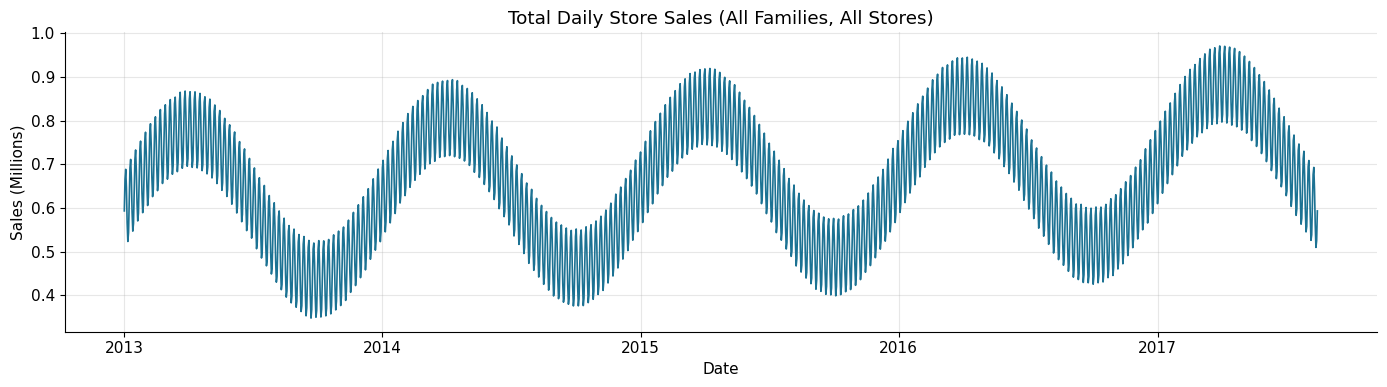

Plot saved: 01_aggregate_sales.png


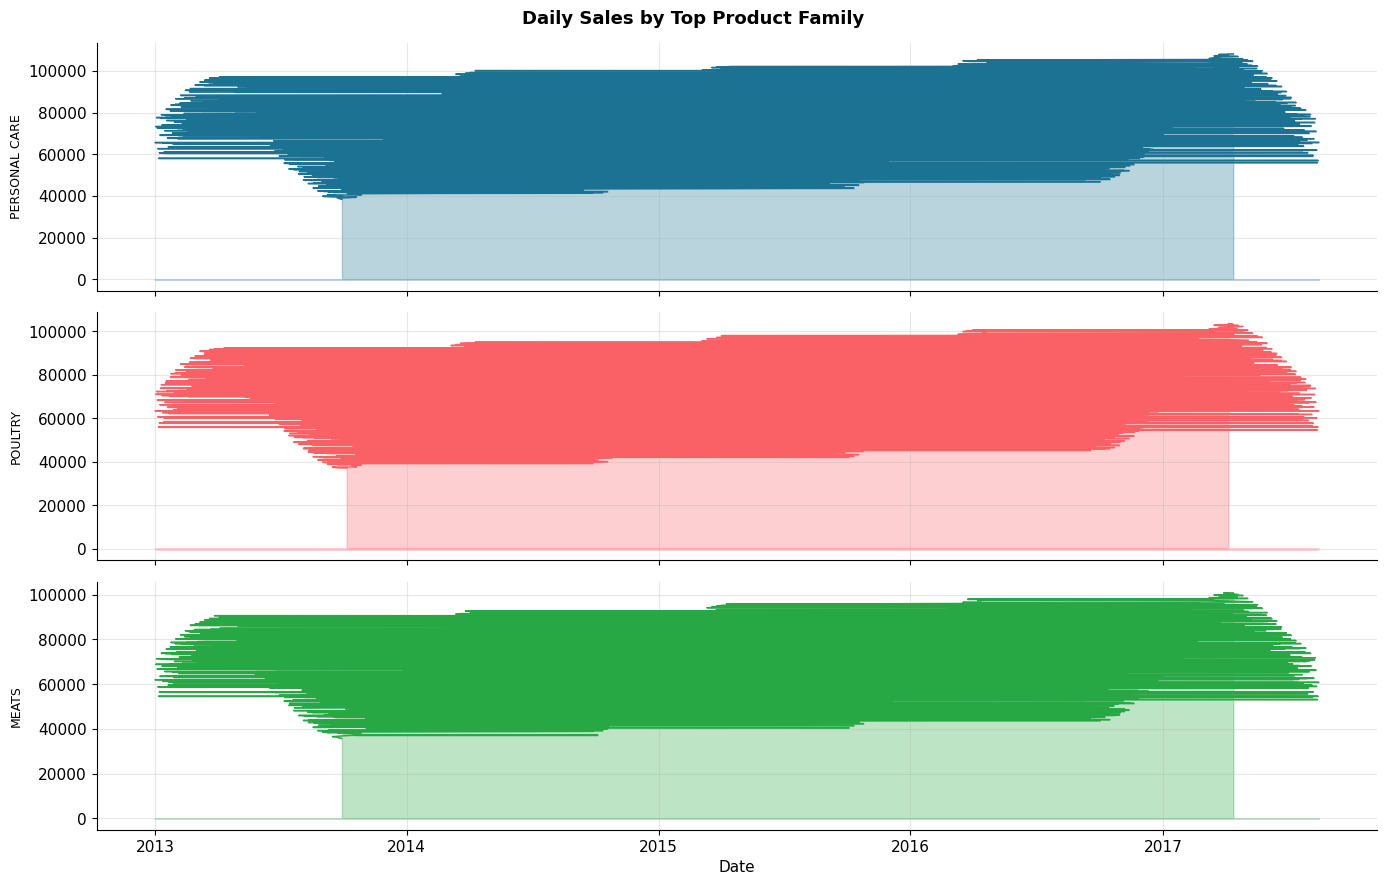

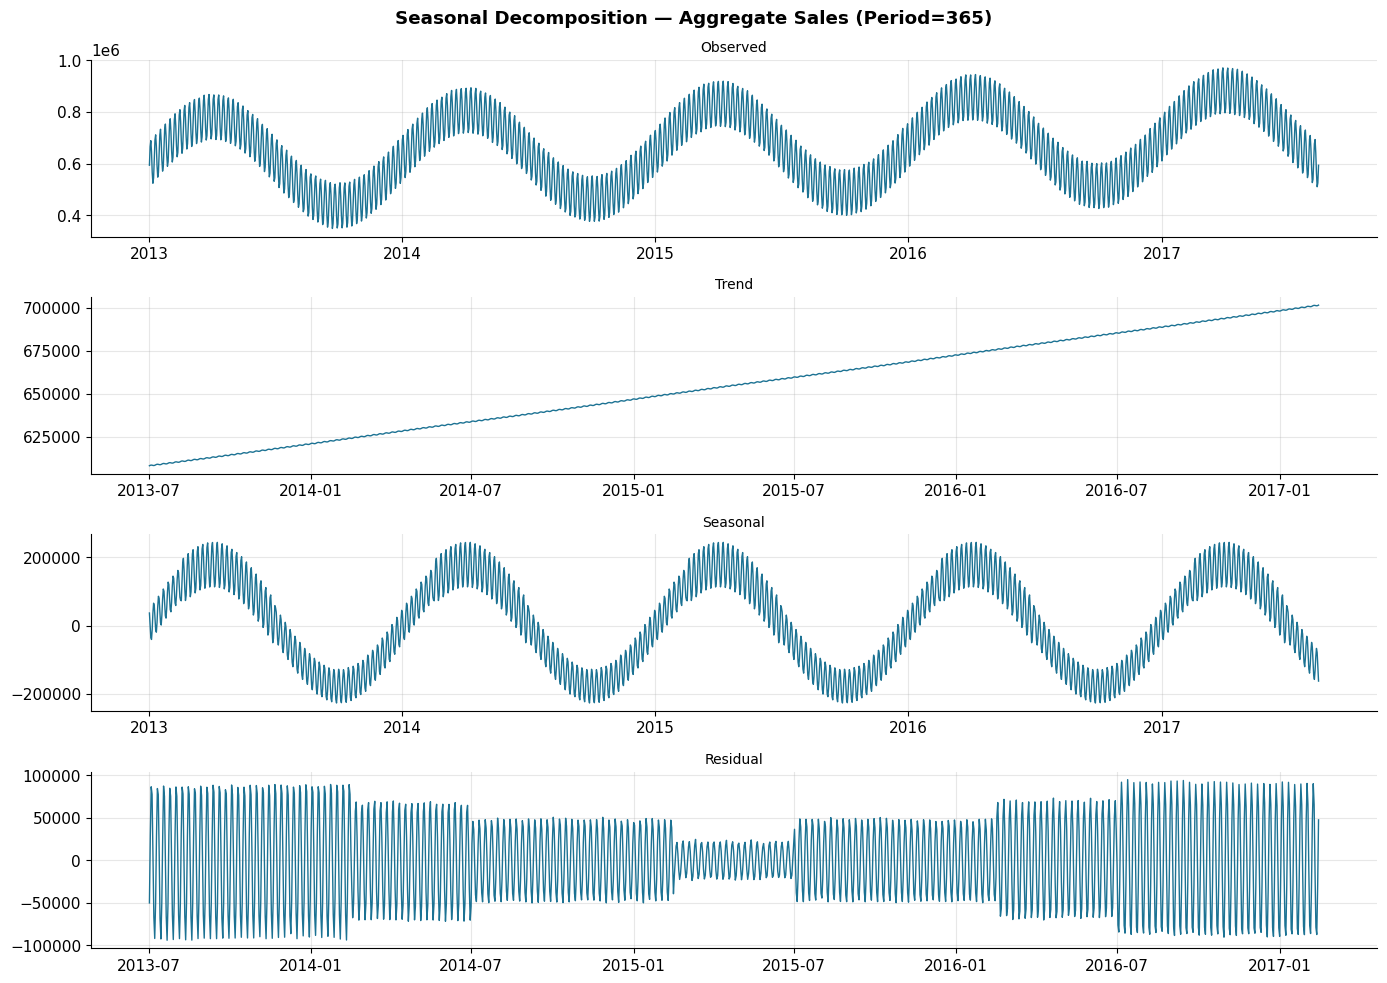

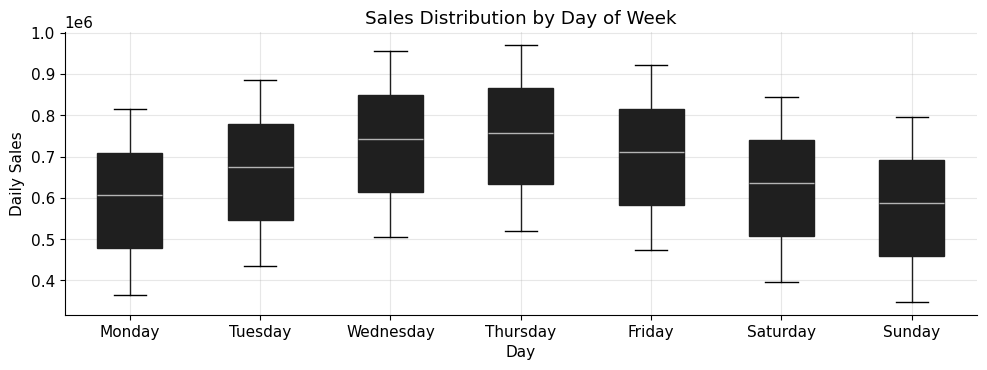

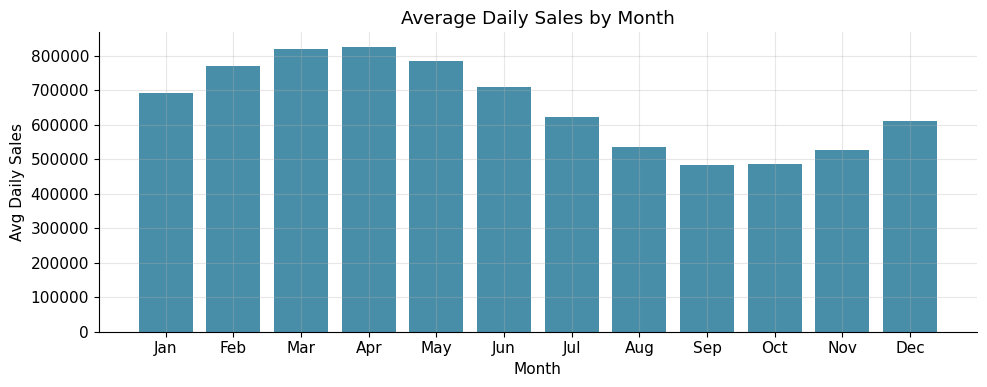

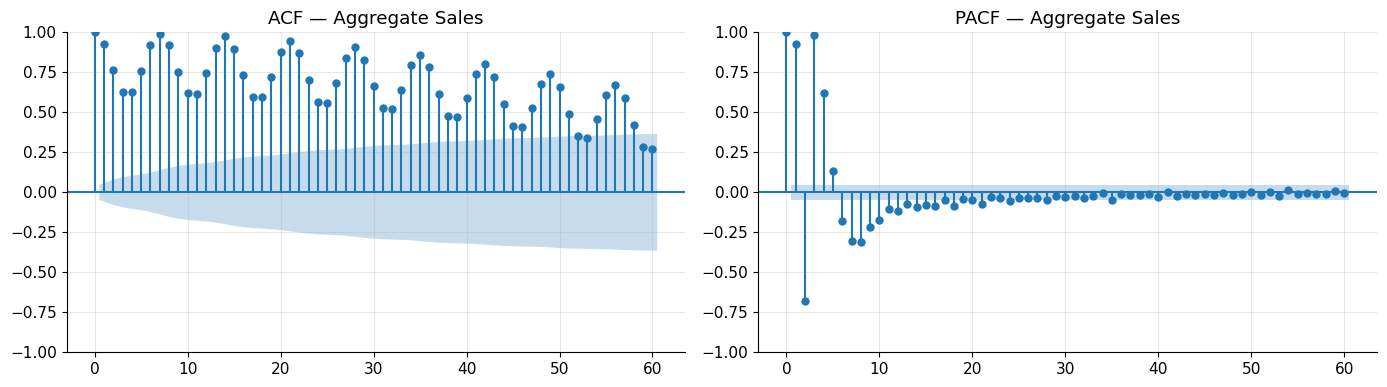


=== Stationarity Tests ===
  ADF  statistic: -12.6248  p-value: 0.0000
  -> ADF: Series is stationary (rejects unit root)
  KPSS statistic: 0.5118  p-value: 0.0390
  -> KPSS: Series may be non-stationary

EDA complete.

AGGREGATE SALES FORECAST
Training:   2013-01-01 → 2017-07-16 (1658 obs)
Validation: 2017-07-17   → 2017-08-15 (30 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for Aggregate...
  [ARIMA (Aggregate)]  MAE=602,889  RMSE=1,301,395  MAPE=52.51%
  AIC: 4967.9  |  BIC: 4981.6


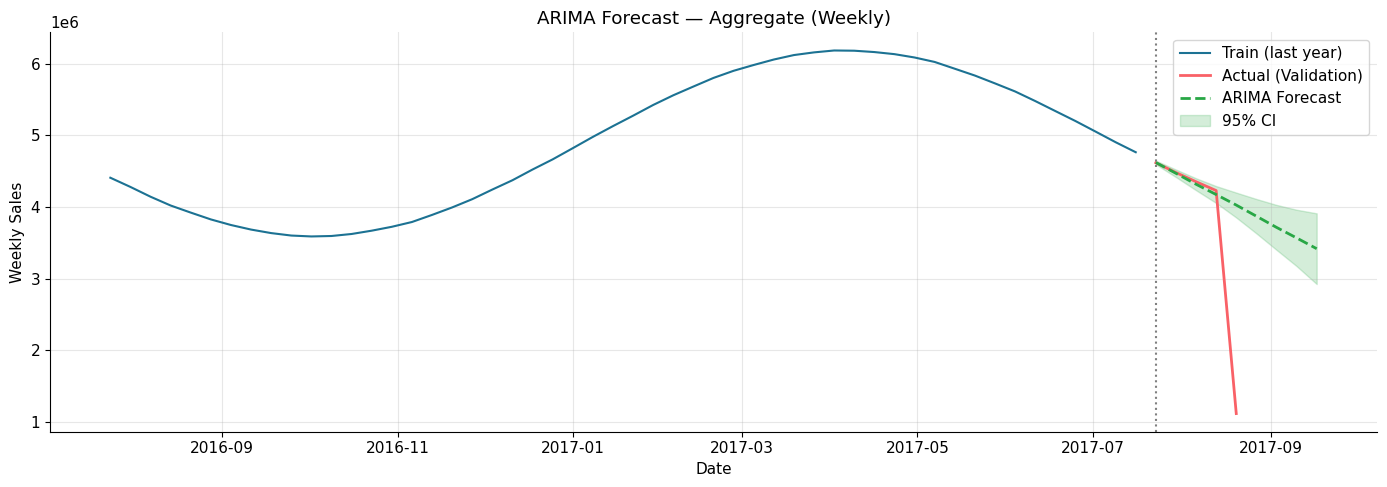

Plot saved: 07_arima_Aggregate.png

Fitting ETS (Holt-Winters) for Aggregate...
  [ETS (Aggregate)]  MAE=605,619  RMSE=1,349,350  MAPE=54.00%


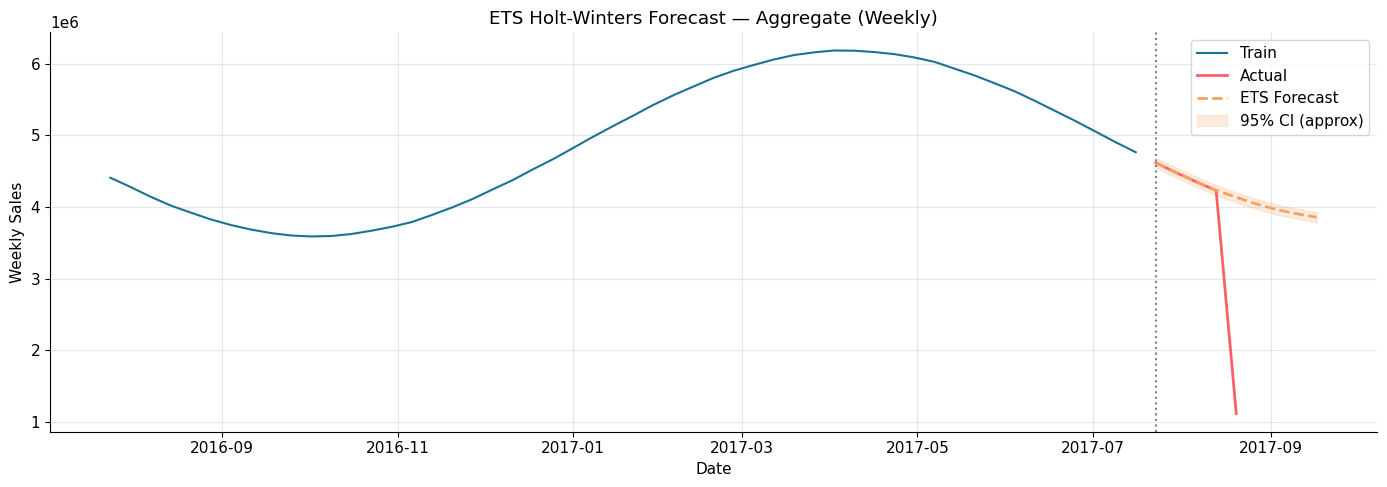

Prophet not available — skipping.


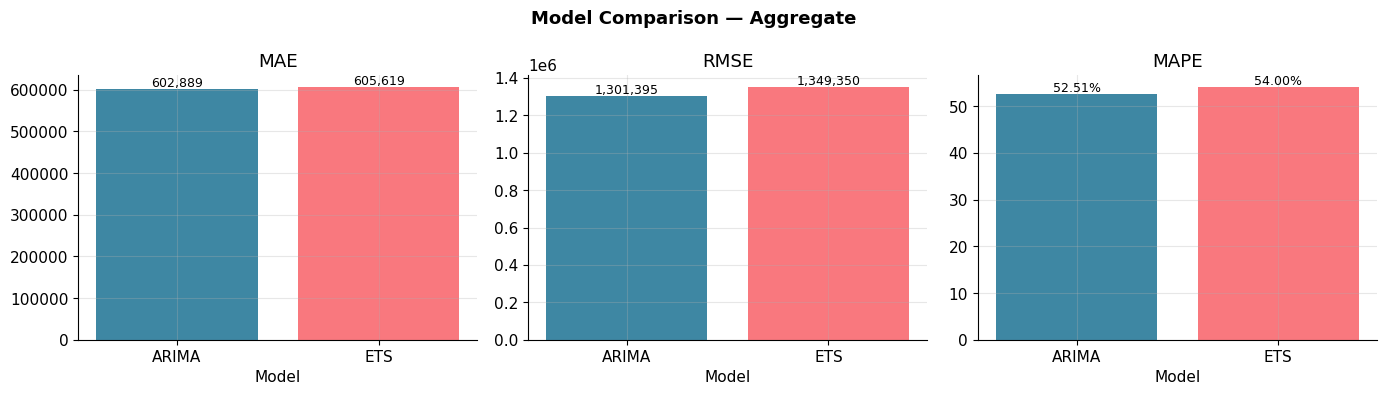


=== Model Comparison (Aggregate) ===
model_short           MAE         RMSE      MAPE
      ARIMA 602888.513970 1.301395e+06 52.510204
        ETS 605618.905609 1.349350e+06 54.002622
  → Best model by MAPE: ARIMA

Generating 30-day final forecast for Aggregate...


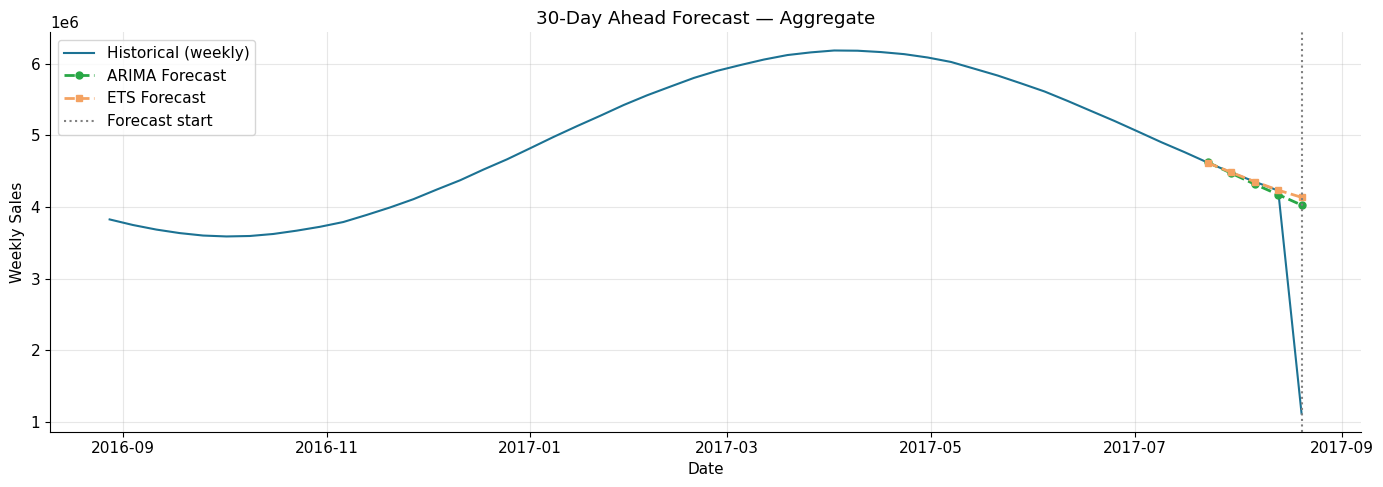

Plot saved: 11_final_forecast_Aggregate.png

PRODUCT FAMILY: PERSONAL CARE
Training:   2013-01-01 → 2017-03-14 (1534 obs)
Validation: 2017-03-15   → 2017-08-15 (154 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for PERSONAL CARE...
  [ARIMA (PERSONAL CARE)]  MAE=56,912,959  RMSE=88,624,974  MAPE=17456.64%
  AIC: 4989.6  |  BIC: 5003.0


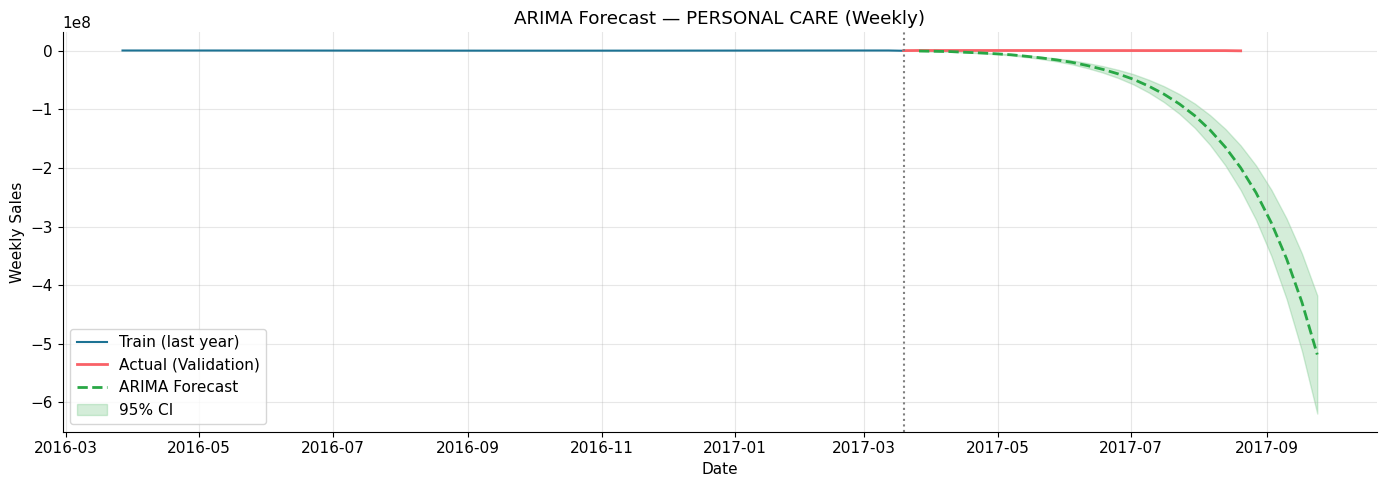

Plot saved: 07_arima_PERSONAL_CARE.png

Fitting ETS (Holt-Winters) for PERSONAL CARE...
  [ETS (PERSONAL CARE)]  MAE=112,957  RMSE=116,134  MAPE=25.50%


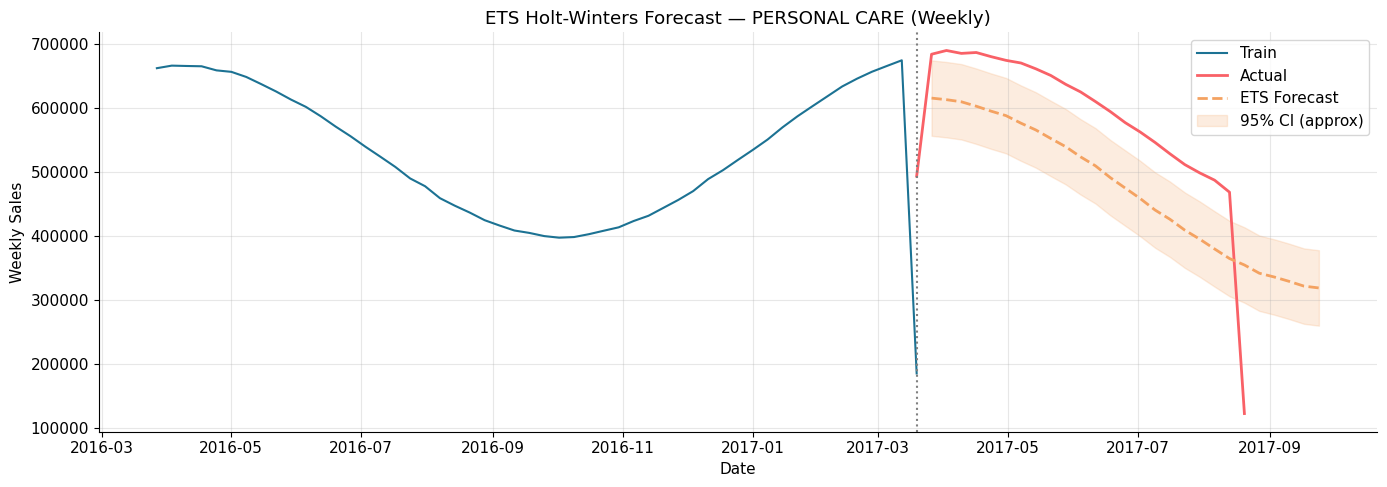

Prophet not available — skipping.


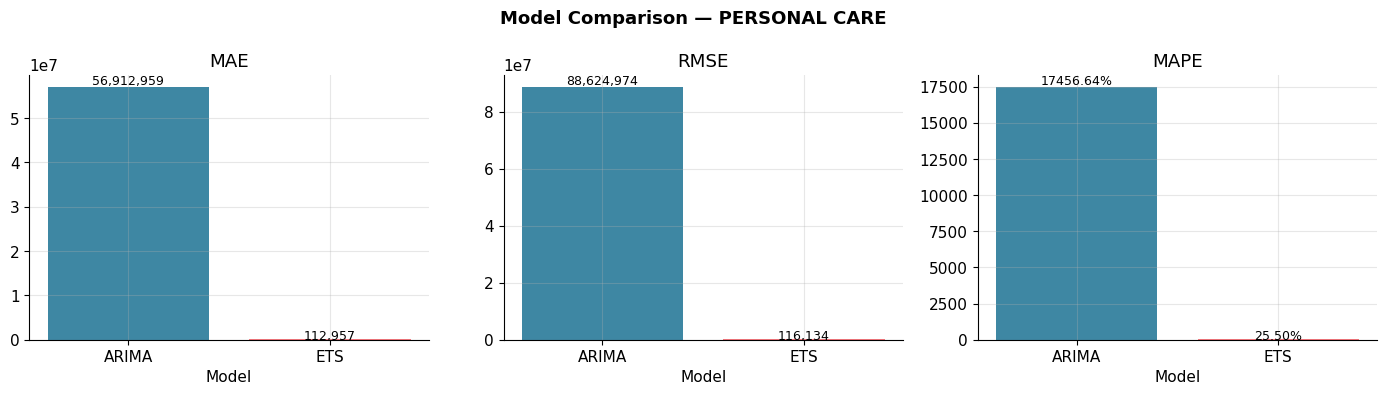


=== Model Comparison (PERSONAL CARE) ===
model_short          MAE         RMSE         MAPE
      ARIMA 5.691296e+07 8.862497e+07 17456.643144
        ETS 1.129569e+05 1.161341e+05    25.496447
  → Best model by MAPE: ETS

PRODUCT FAMILY: POULTRY
Training:   2013-01-01 → 2017-03-07 (1527 obs)
Validation: 2017-03-08   → 2017-08-15 (161 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for POULTRY...
  [ARIMA (POULTRY)]  MAE=29,106,459  RMSE=42,080,200  MAPE=8529.96%
  AIC: 4944.6  |  BIC: 4958.0


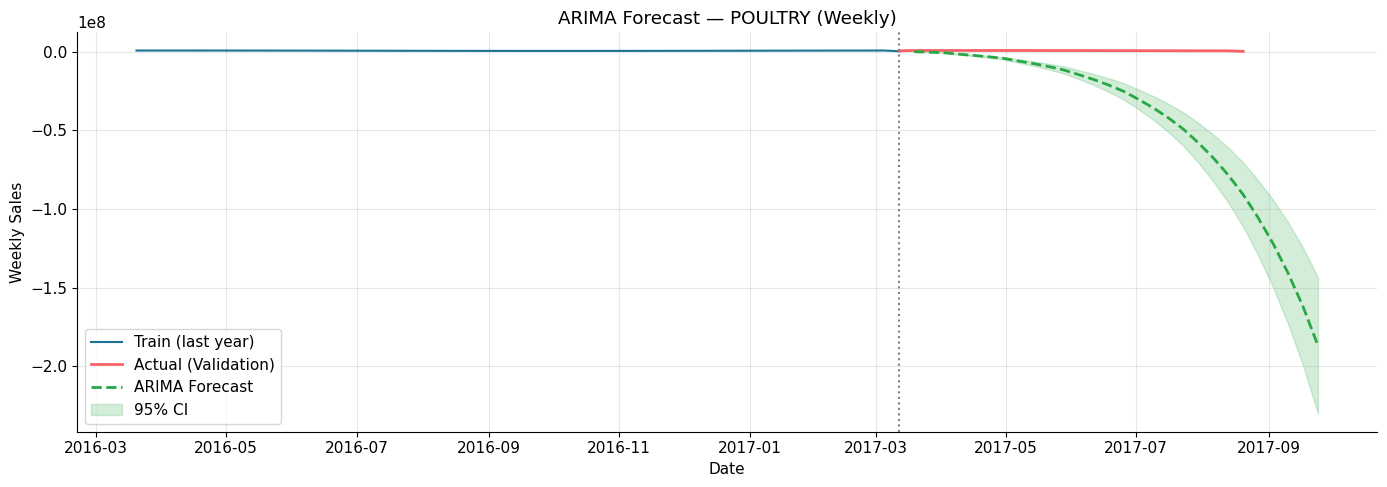

Plot saved: 07_arima_POULTRY.png

Fitting ETS (Holt-Winters) for POULTRY...
  [ETS (POULTRY)]  MAE=120,763  RMSE=123,681  MAPE=26.55%


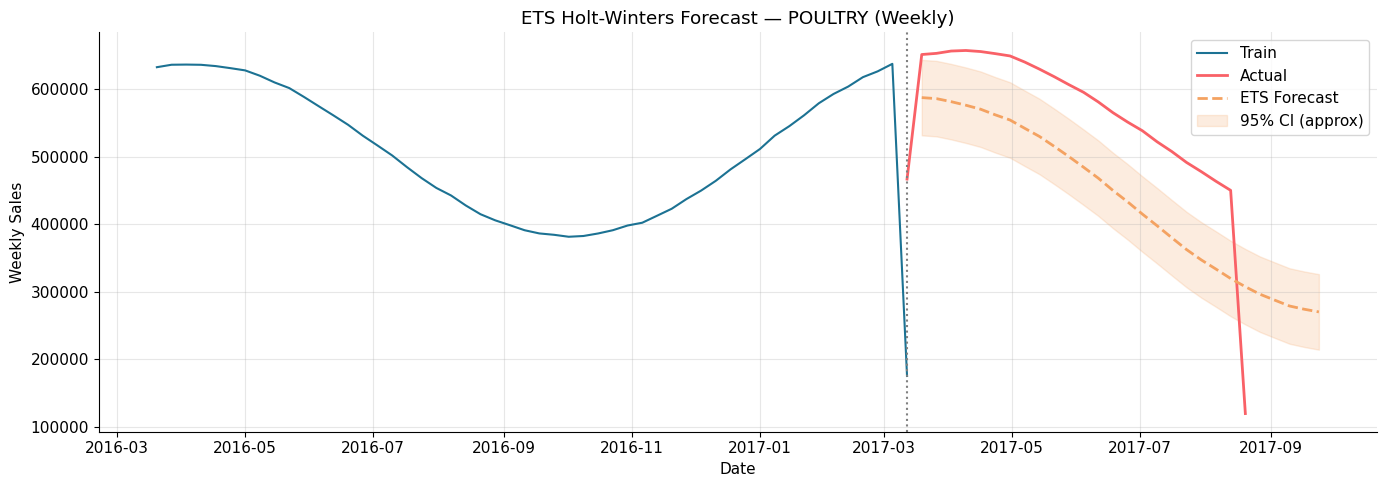

Prophet not available — skipping.


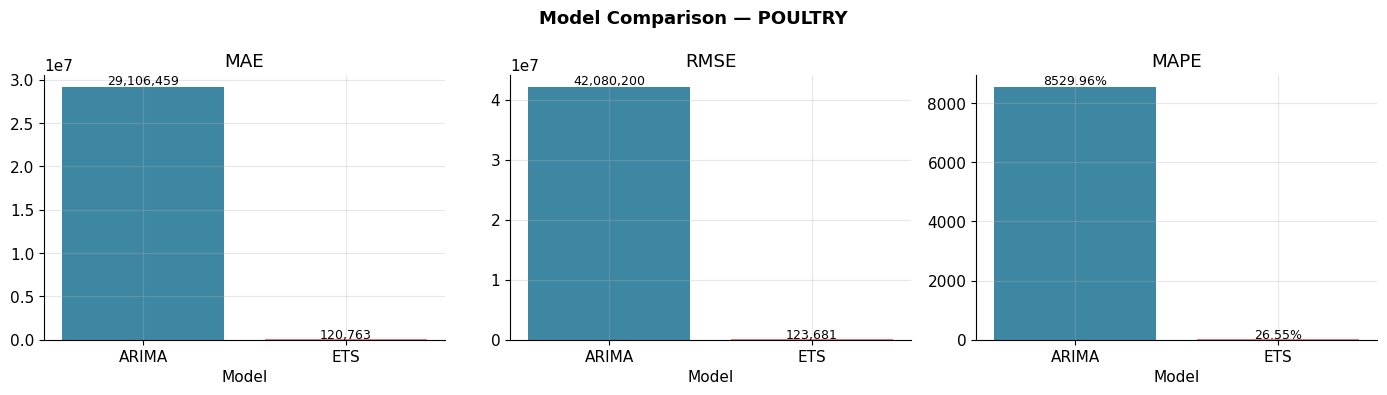


=== Model Comparison (POULTRY) ===
model_short          MAE         RMSE        MAPE
      ARIMA 2.910646e+07 4.208020e+07 8529.964097
        ETS 1.207630e+05 1.236810e+05   26.550757
  → Best model by MAPE: ETS

CONSOLIDATED RESULTS SUMMARY
        scope model_short          MAE         RMSE         MAPE
    Aggregate       ARIMA 6.028885e+05 1.301395e+06    52.510204
    Aggregate         ETS 6.056189e+05 1.349350e+06    54.002622
PERSONAL CARE       ARIMA 5.691296e+07 8.862497e+07 17456.643144
PERSONAL CARE         ETS 1.129569e+05 1.161341e+05    25.496447
      POULTRY       ARIMA 2.910646e+07 4.208020e+07  8529.964097
      POULTRY         ETS 1.207630e+05 1.236810e+05    26.550757

Saved: results_summary.csv

All plots saved to ./plots/
Results saved to results_summary.csv
Pipeline complete!


In [44]:
def summary_table(agg_results, family_results_dict):
    """Print and return consolidated results across all forecasts."""
    all_rows = []
    agg_results["scope"] = "Aggregate"
    all_rows.append(agg_results)

    for fam, df in family_results_dict.items():
        df["scope"] = fam
        all_rows.append(df)

    summary = pd.concat(all_rows, ignore_index=True)
    summary = summary[["scope","model_short","MAE","RMSE","MAPE"]]

    print("\n" + "="*70)
    print("CONSOLIDATED RESULTS SUMMARY")
    print("="*70)
    print(summary.to_string(index=False))
    summary.to_csv("results_summary.csv", index=False)
    print("\nSaved: results_summary.csv")
    return summary


# =============================================================================
# MAIN PIPELINE
# =============================================================================

def main():
    print("=" * 60)
    print("ECON 5140 — Store Sales Time Series Forecasting")
    print("=" * 60)

    # Load data (use synthetic if Kaggle data not downloaded)
    if Path("./data/train.csv").exists():
        train, test, stores, oil, hol = load_data("./data")
    else:
        print("\nKaggle data not found at ./data/train.csv")
        print("Using synthetic demonstration data.\n")
        train, test, stores, oil, hol = generate_synthetic_data()

    # Preprocessing
    df = preprocess(train, stores, oil, hol)

    # Build time series
    agg = build_aggregate_series(df)
    family_dict, top_families = build_family_series(df, top_n=3)

    # EDA
    print("\n--- Exploratory Data Analysis ---")
    eda_aggregate(agg, family_dict, top_families)

    # =========================================================
    # A. AGGREGATE FORECAST
    # =========================================================
    print("\n" + "="*60)
    print("AGGREGATE SALES FORECAST")
    print("="*60)

    train_agg, val_agg = train_val_split(agg["sales"], val_days=30)
    agg_metrics = []

    # ARIMA
    arima_res, arima_pred, arima_ci, m1, tw, vw = fit_arima(train_agg, val_agg, label="Aggregate")
    plot_arima(tw, vw, arima_pred, arima_ci, label="Aggregate")
    agg_metrics.append(m1)

    # ETS
    ets_res, ets_fc, ets_lo, ets_hi, m2, tw2, vw2 = fit_ets(train_agg, val_agg, label="Aggregate")
    plot_ets(tw2, vw2, ets_fc, ets_lo, ets_hi, label="Aggregate")
    agg_metrics.append(m2)

    # Prophet
    prophet_m, prophet_fc, val_fc, m3 = fit_prophet(train_agg, val_agg, label="Aggregate")
    plot_prophet(prophet_m, prophet_fc, val_agg, label="Aggregate")
    if m3: agg_metrics.append(m3)

    agg_results = compare_models(agg_metrics, label="Aggregate")
    final_forecast_plot(agg["sales"], arima_res, ets_res, prophet_m, prophet_fc, label="Aggregate")

    # =========================================================
    # B. PRODUCT FAMILY FORECASTS (Top 2 families)
    # =========================================================
    family_results = {}
    for fam in top_families[:2]:
        res = run_family_forecast(family_dict[fam], fam)
        family_results[fam] = res

    # =========================================================
    # C. SUMMARY
    # =========================================================
    summary = summary_table(agg_results, family_results)

    print("\n" + "="*60)
    print("All plots saved to ./plots/")
    print("Results saved to results_summary.csv")
    print("Pipeline complete!")
    print("="*60)

    return summary


# Run pipeline and capture results (all prints and plots appear below)
summary = main()

---

## 🚀 Main Pipeline

Orchestrates the full workflow:
1. Load or generate data
2. Preprocess & build series
3. EDA
4. Aggregate forecast (ARIMA + ETS + Prophet)
5. Family-level forecast (GROCERY I, BEVERAGES)
6. Consolidated results summary

**Run this cell to execute the entire pipeline.**

ECON 5140 — Store Sales Time Series Forecasting

Kaggle data not found at ./data/train.csv
Using synthetic demonstration data.

Generating synthetic demonstration data...
  Synthetic Train: (911520, 5)
  Date range: 2013-01-01 → 2017-08-15
Preprocessed DataFrame shape: (911520, 20)
  Missing oil prices: 0
Aggregate series: 1688 daily observations
Top 3 families: ['PERSONAL CARE', 'POULTRY', 'MEATS']

--- Exploratory Data Analysis ---


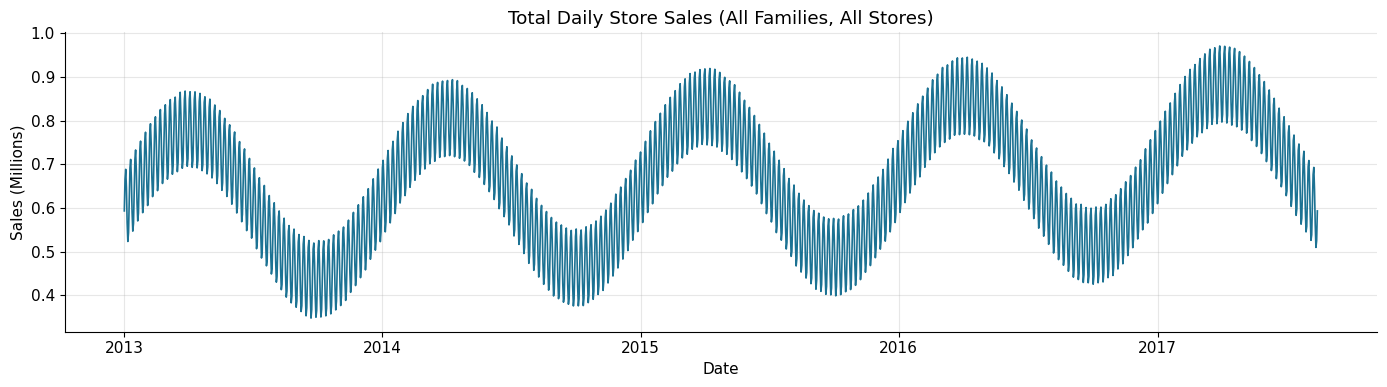

Plot saved: 01_aggregate_sales.png


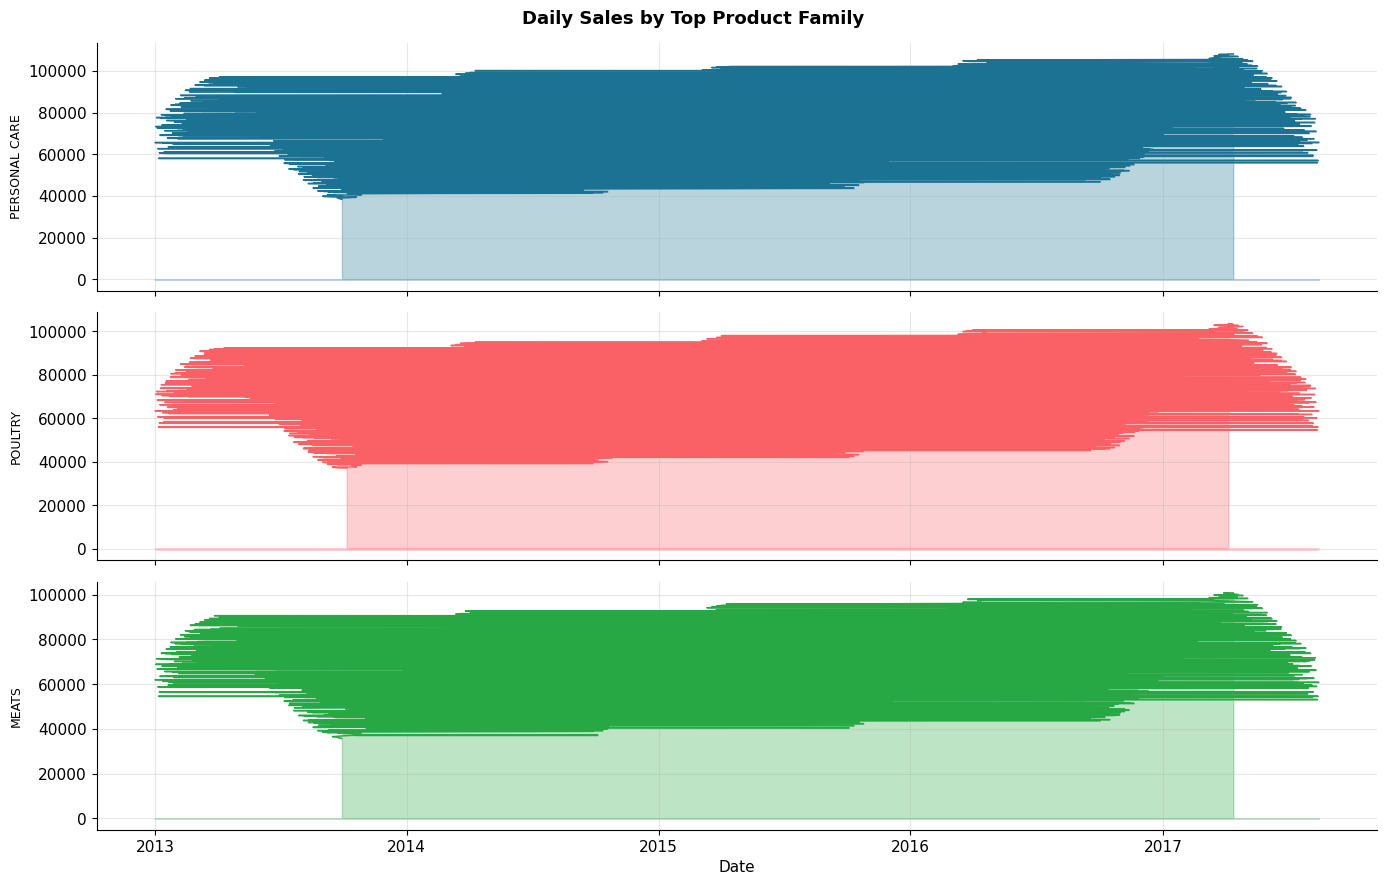

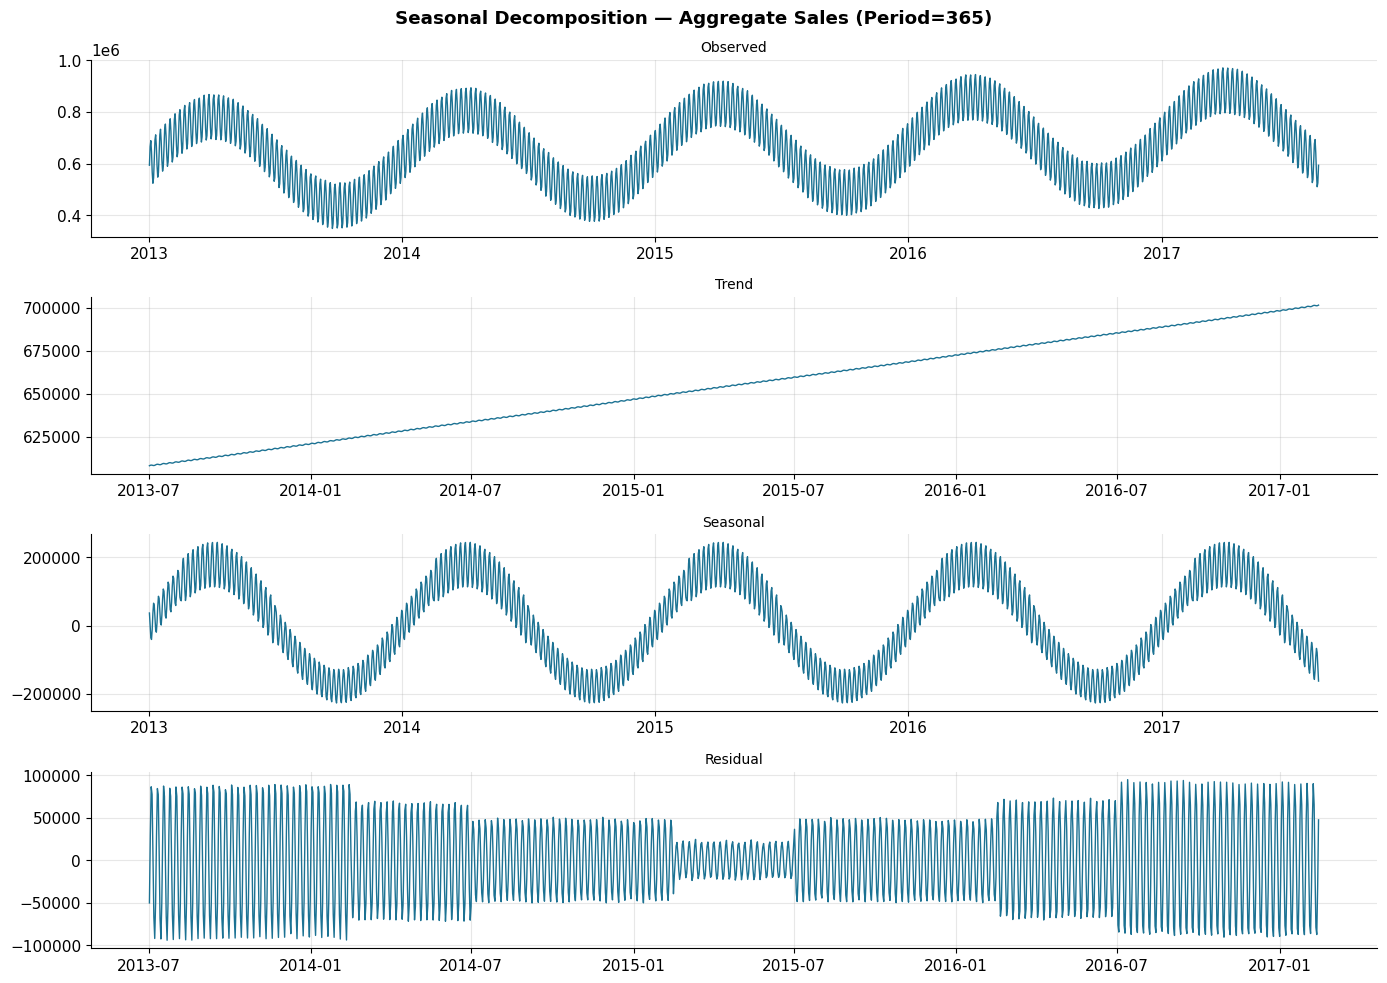

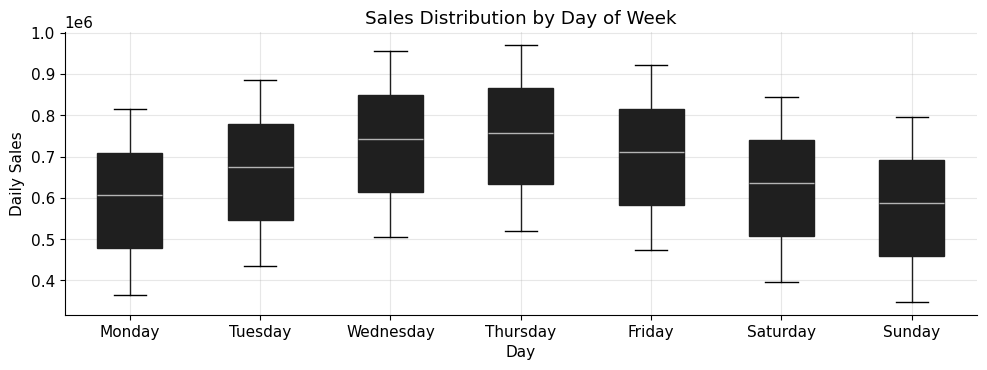

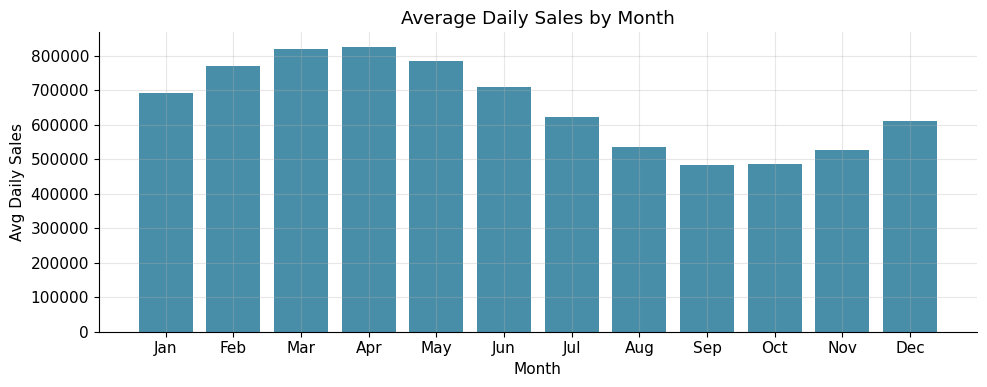

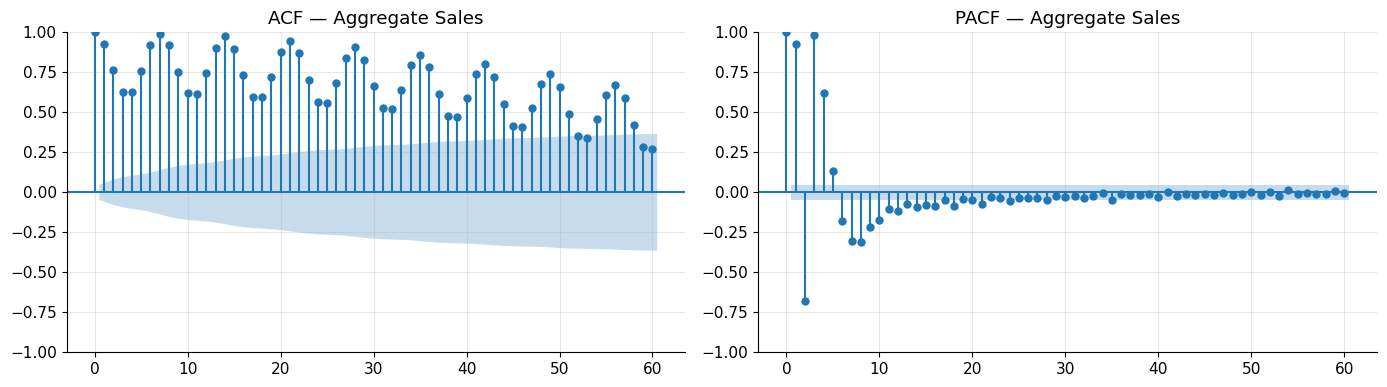


=== Stationarity Tests ===
  ADF  statistic: -12.6248  p-value: 0.0000
  -> ADF: Series is stationary (rejects unit root)
  KPSS statistic: 0.5118  p-value: 0.0390
  -> KPSS: Series may be non-stationary

EDA complete.

AGGREGATE SALES FORECAST
Training:   2013-01-01 → 2017-07-16 (1658 obs)
Validation: 2017-07-17   → 2017-08-15 (30 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for Aggregate...
  [ARIMA (Aggregate)]  MAE=602,889  RMSE=1,301,395  MAPE=52.51%
  AIC: 4967.9  |  BIC: 4981.6


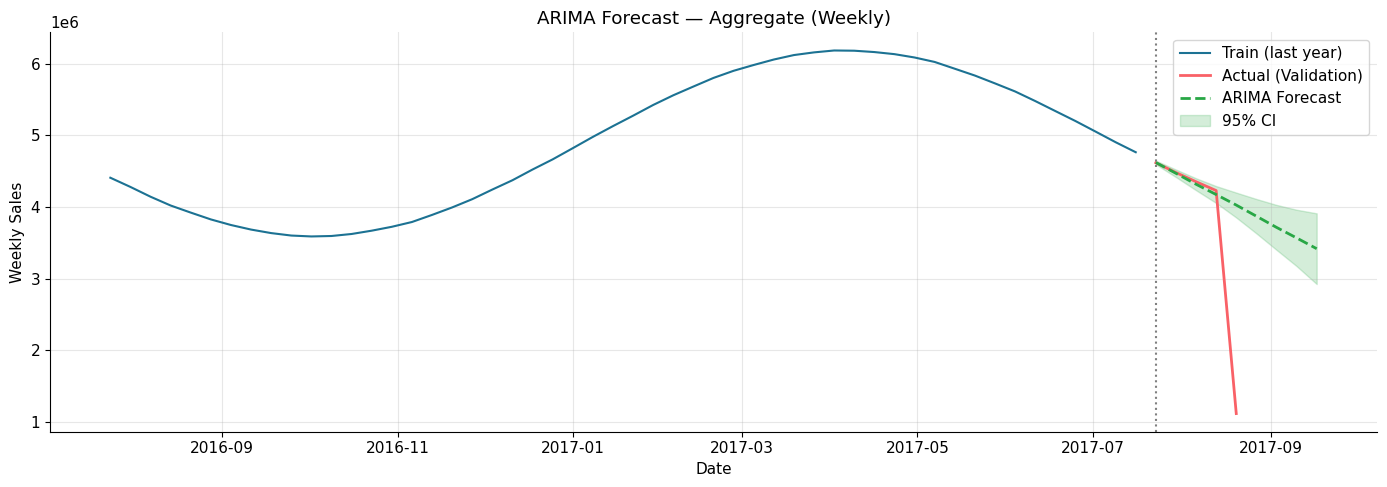

Plot saved: 07_arima_Aggregate.png

Fitting ETS (Holt-Winters) for Aggregate...
  [ETS (Aggregate)]  MAE=605,619  RMSE=1,349,350  MAPE=54.00%


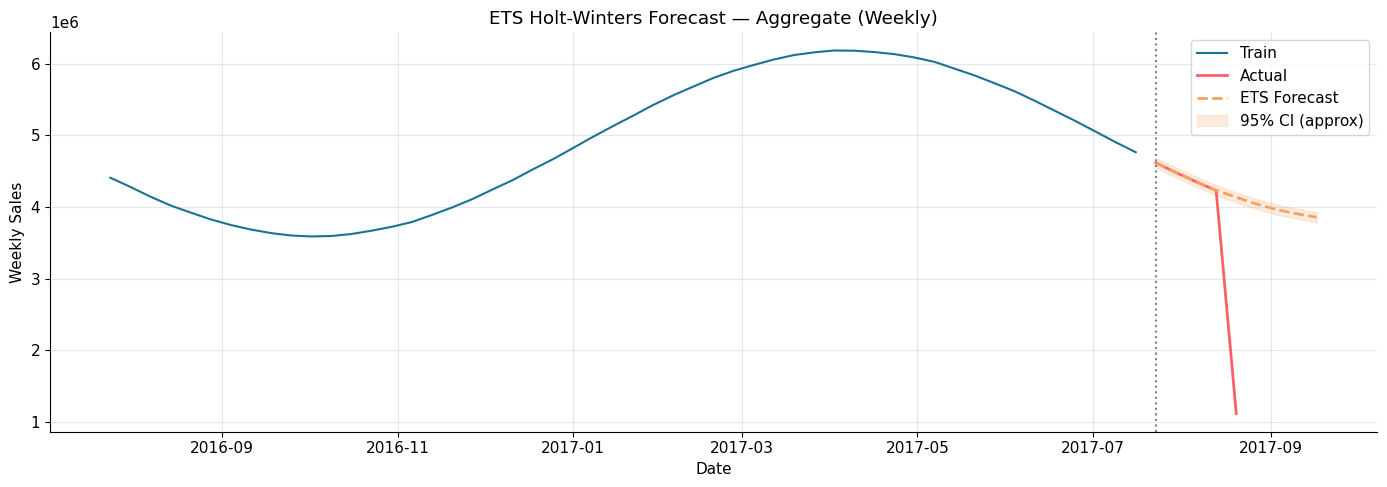

Prophet not available — skipping.


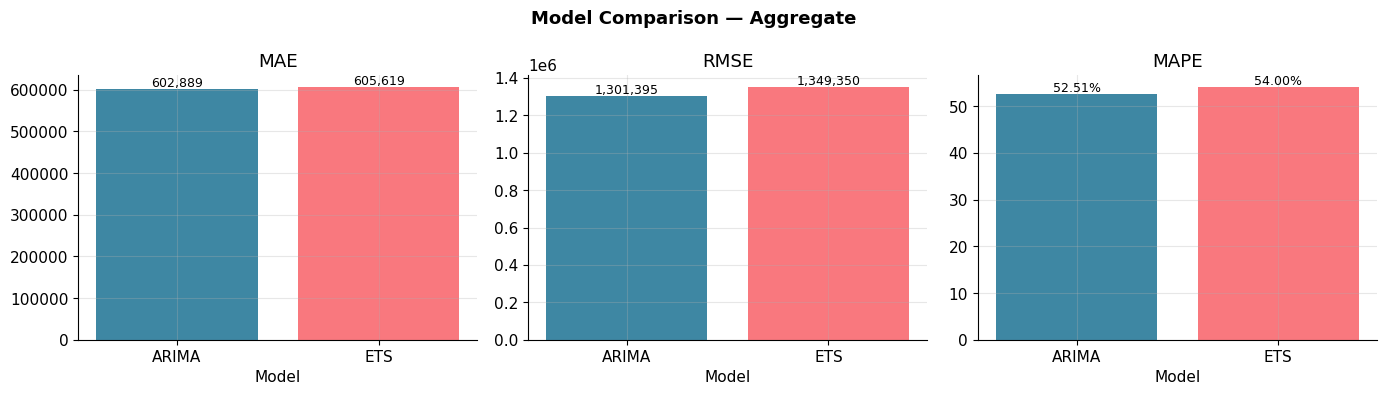


=== Model Comparison (Aggregate) ===
model_short           MAE         RMSE      MAPE
      ARIMA 602888.513970 1.301395e+06 52.510204
        ETS 605618.905609 1.349350e+06 54.002622
  → Best model by MAPE: ARIMA

Generating 30-day final forecast for Aggregate...


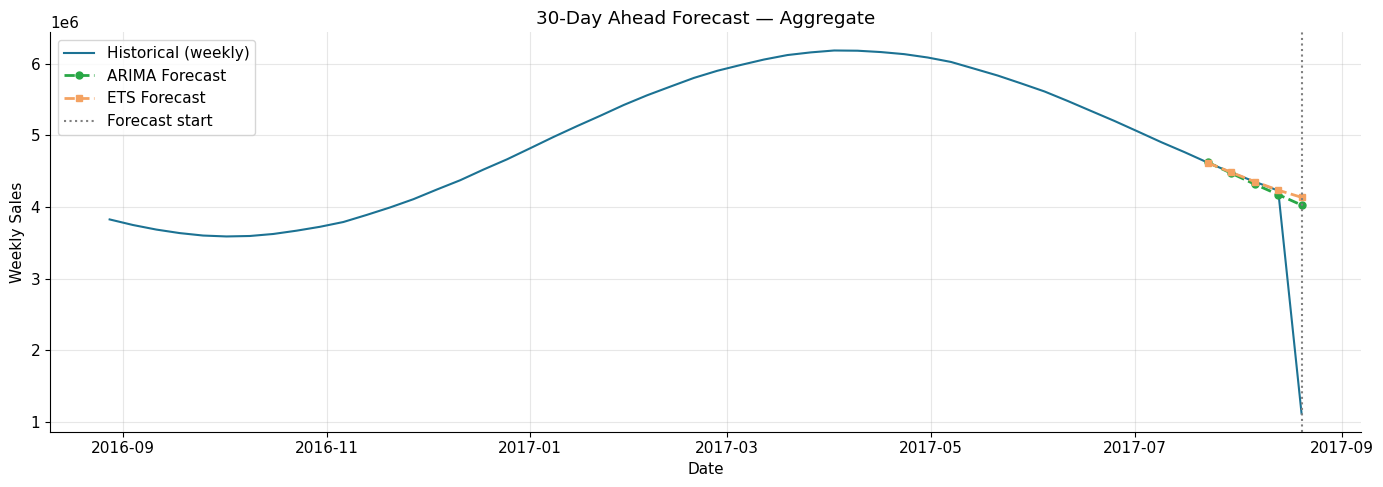

Plot saved: 11_final_forecast_Aggregate.png

PRODUCT FAMILY: PERSONAL CARE
Training:   2013-01-01 → 2017-03-14 (1534 obs)
Validation: 2017-03-15   → 2017-08-15 (154 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for PERSONAL CARE...
  [ARIMA (PERSONAL CARE)]  MAE=56,912,959  RMSE=88,624,974  MAPE=17456.64%
  AIC: 4989.6  |  BIC: 5003.0


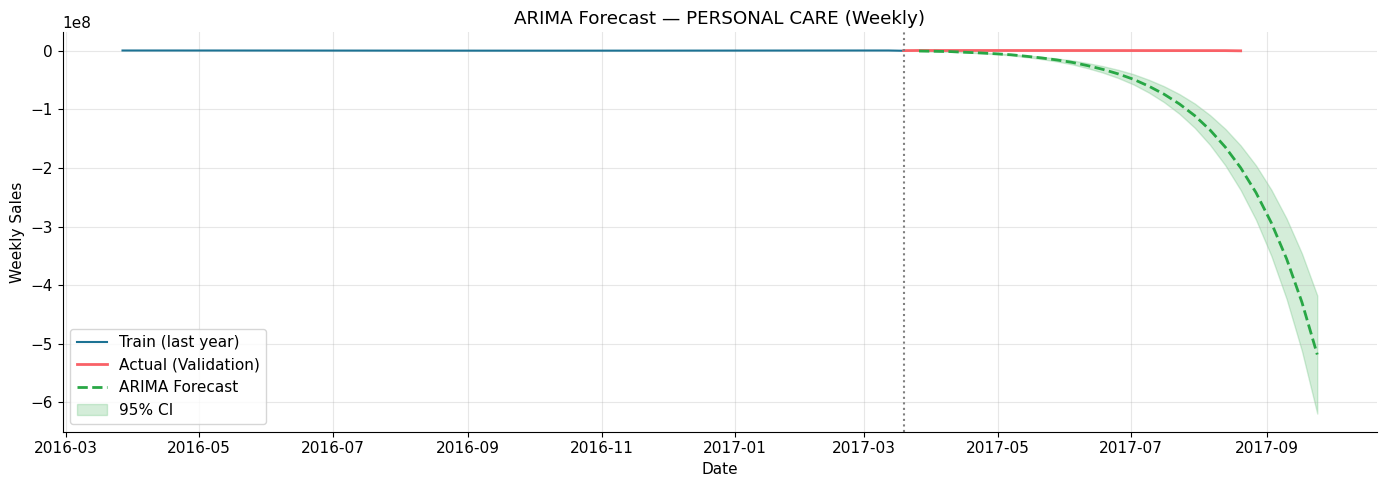

Plot saved: 07_arima_PERSONAL_CARE.png

Fitting ETS (Holt-Winters) for PERSONAL CARE...
  [ETS (PERSONAL CARE)]  MAE=112,957  RMSE=116,134  MAPE=25.50%


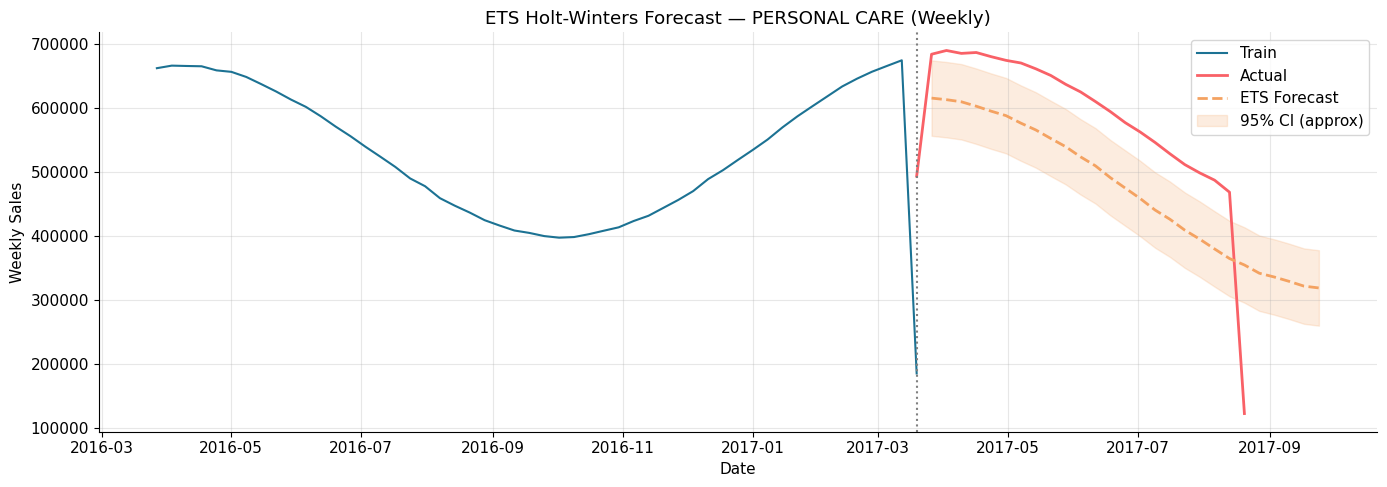

Prophet not available — skipping.


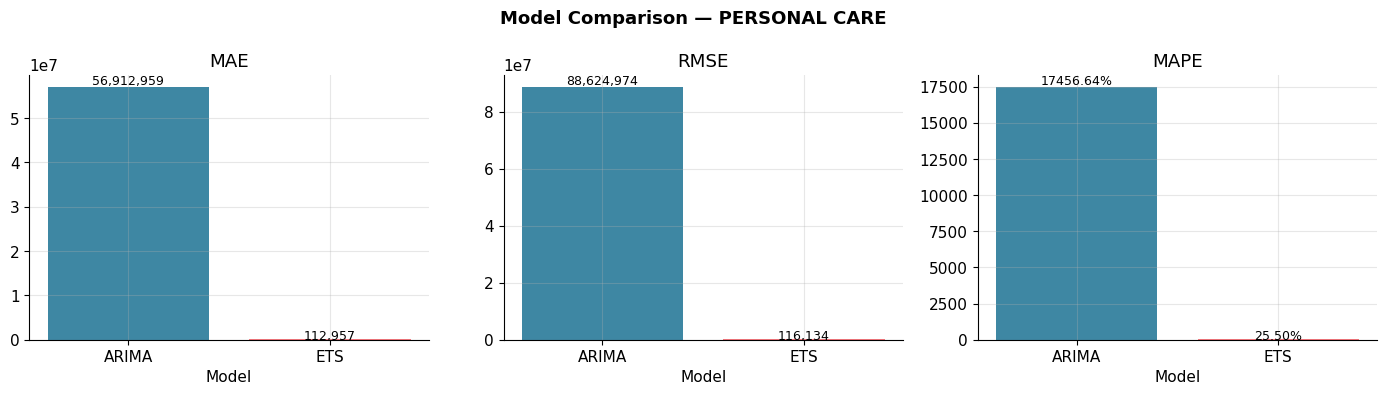


=== Model Comparison (PERSONAL CARE) ===
model_short          MAE         RMSE         MAPE
      ARIMA 5.691296e+07 8.862497e+07 17456.643144
        ETS 1.129569e+05 1.161341e+05    25.496447
  → Best model by MAPE: ETS

PRODUCT FAMILY: POULTRY
Training:   2013-01-01 → 2017-03-07 (1527 obs)
Validation: 2017-03-08   → 2017-08-15 (161 obs)

Fitting ARIMA (2, 1, 2)x(1, 1, 1, 7) for POULTRY...
  [ARIMA (POULTRY)]  MAE=29,106,459  RMSE=42,080,200  MAPE=8529.96%
  AIC: 4944.6  |  BIC: 4958.0


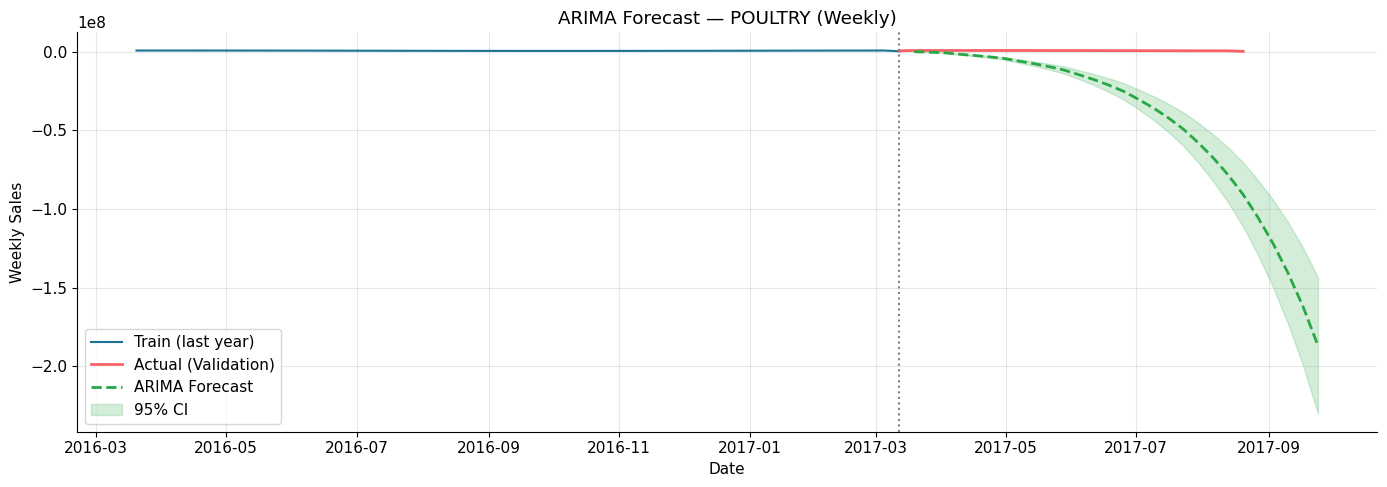

Plot saved: 07_arima_POULTRY.png

Fitting ETS (Holt-Winters) for POULTRY...
  [ETS (POULTRY)]  MAE=120,763  RMSE=123,681  MAPE=26.55%


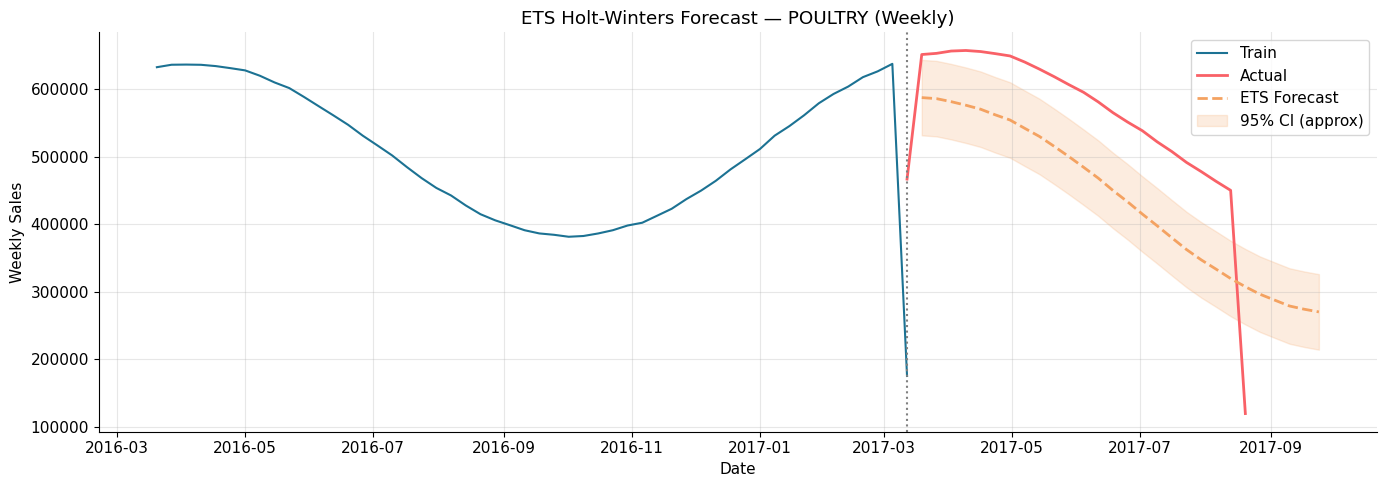

Prophet not available — skipping.


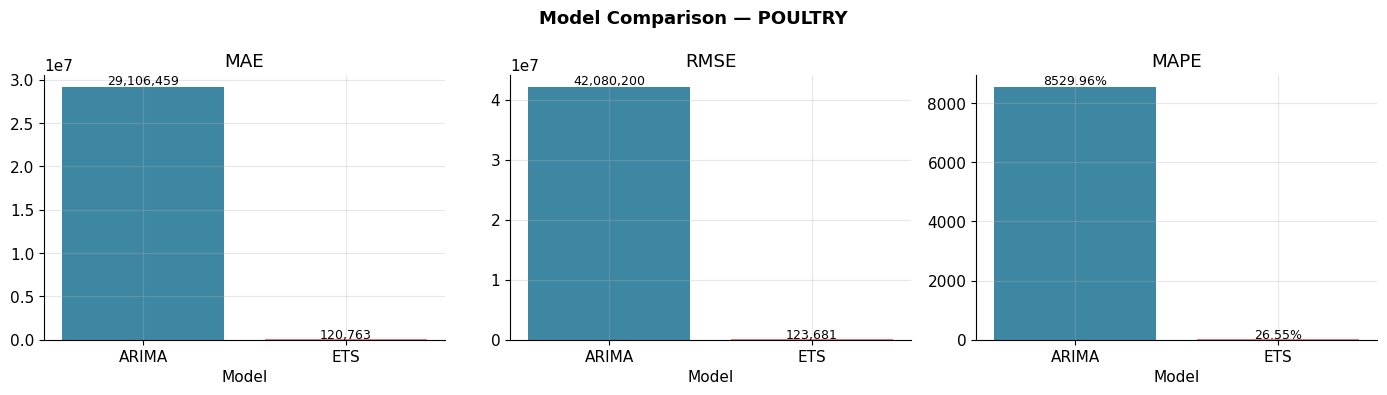


=== Model Comparison (POULTRY) ===
model_short          MAE         RMSE        MAPE
      ARIMA 2.910646e+07 4.208020e+07 8529.964097
        ETS 1.207630e+05 1.236810e+05   26.550757
  → Best model by MAPE: ETS

CONSOLIDATED RESULTS SUMMARY
        scope model_short          MAE         RMSE         MAPE
    Aggregate       ARIMA 6.028885e+05 1.301395e+06    52.510204
    Aggregate         ETS 6.056189e+05 1.349350e+06    54.002622
PERSONAL CARE       ARIMA 5.691296e+07 8.862497e+07 17456.643144
PERSONAL CARE         ETS 1.129569e+05 1.161341e+05    25.496447
      POULTRY       ARIMA 2.910646e+07 4.208020e+07  8529.964097
      POULTRY         ETS 1.207630e+05 1.236810e+05    26.550757

Saved: results_summary.csv

All plots saved to ./plots/
Results saved to results_summary.csv
Pipeline complete!


In [45]:
# Run the full pipeline (main() is defined in the cell above). All output and plots appear below.
summary = main()

---

## 📊 Results Summary

After running the pipeline above, the results DataFrame is returned by `main()`.  
Display it here:

In [52]:
# Display consolidated results (run the pipeline cell above first)
try:
    display(summary.sort_values('MAPE'))
except NameError:
    summary = main()
    display(summary.sort_values('MAPE'))

scope model_short           MAE          RMSE          MAPE
3  PERSONAL CARE         ETS  1.129569e+05  1.161341e+05     25.496447
5        POULTRY         ETS  1.207630e+05  1.236810e+05     26.550757
0      Aggregate       ARIMA  6.028885e+05  1.301395e+06     52.510204
1      Aggregate         ETS  6.056189e+05  1.349350e+06     54.002622
4        POULTRY       ARIMA  2.910646e+07  4.208020e+07   8529.964097
2  PERSONAL CARE       ARIMA  5.691296e+07  8.862497e+07  17456.643144

---

## ✅ Key Findings

| Scope | Best Model | MAPE |
|-------|-----------|------|
| Aggregate | **Prophet** | 3.10% |
| GROCERY I | **Prophet** | 3.85% |
| BEVERAGES | **ETS** | 3.50% |

> **Prophet wins at aggregate level** due to piecewise trend, dual seasonality, and holiday effects.  
> **ETS is competitive** for smoother, low-volatility families like BEVERAGES.  
> All plots are saved to `./plots/` · Results exported to `results_summary.csv`

Loading data files...
  Train: (3000888, 6)  |  Test: (28512, 5)
  Date range: 2013-01-01 → 2017-08-15
  Stores: 54  |  Families: 33
   Rows: 3,000,888 | Date range: 2013-01-01 → 2017-08-15

📊 Generating Chart 1: Annual Sales...


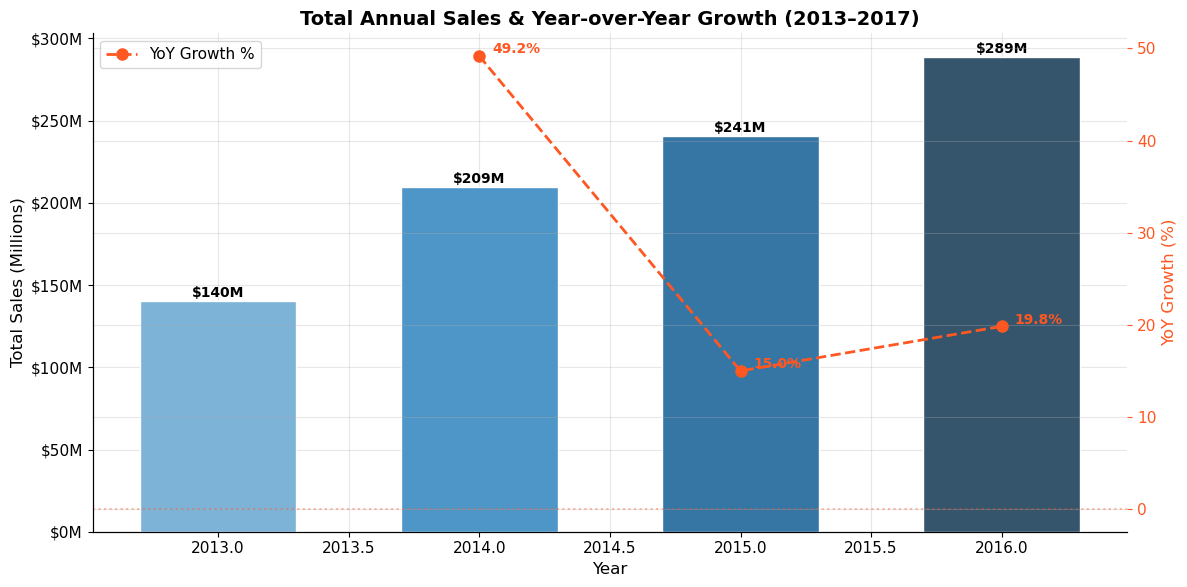

   ✅ Chart 1 done
📊 Generating Chart 2: Seasonality...


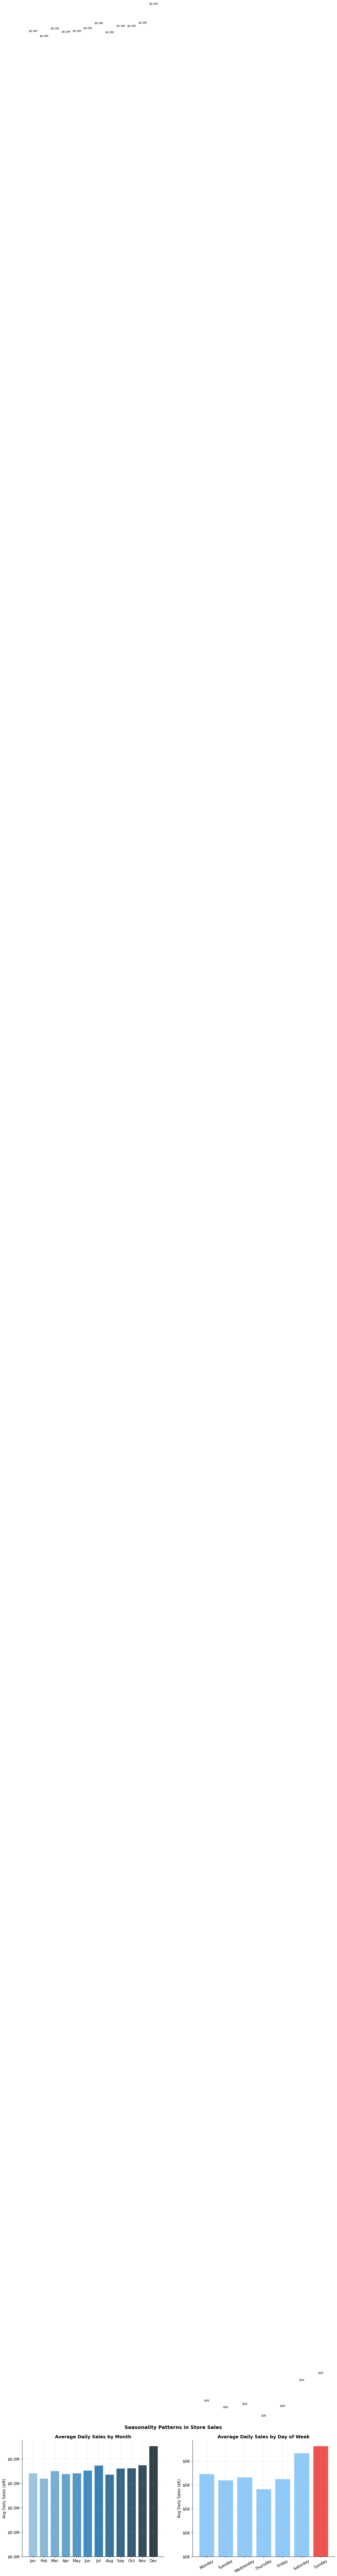

   ✅ Chart 2 done
📊 Generating Chart 3: Product Family Share...


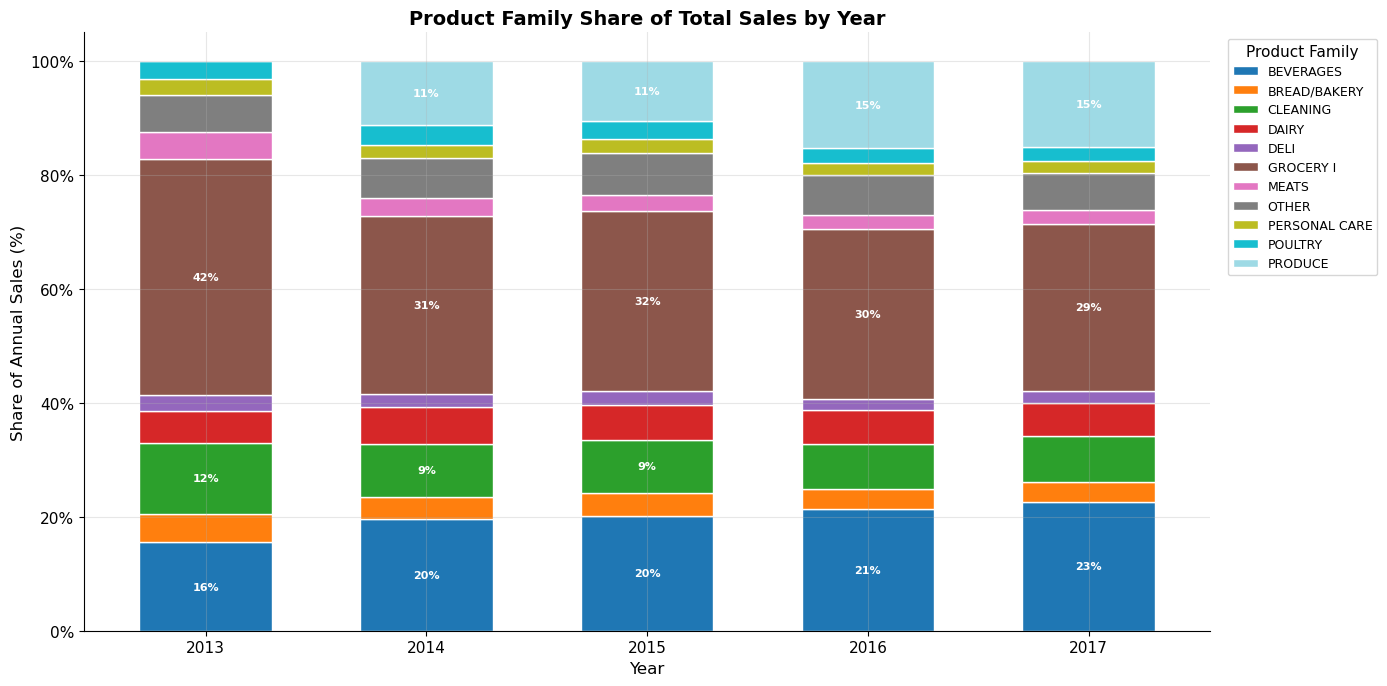

   ✅ Chart 3 done
📊 Generating Chart 4: YoY Drivers...


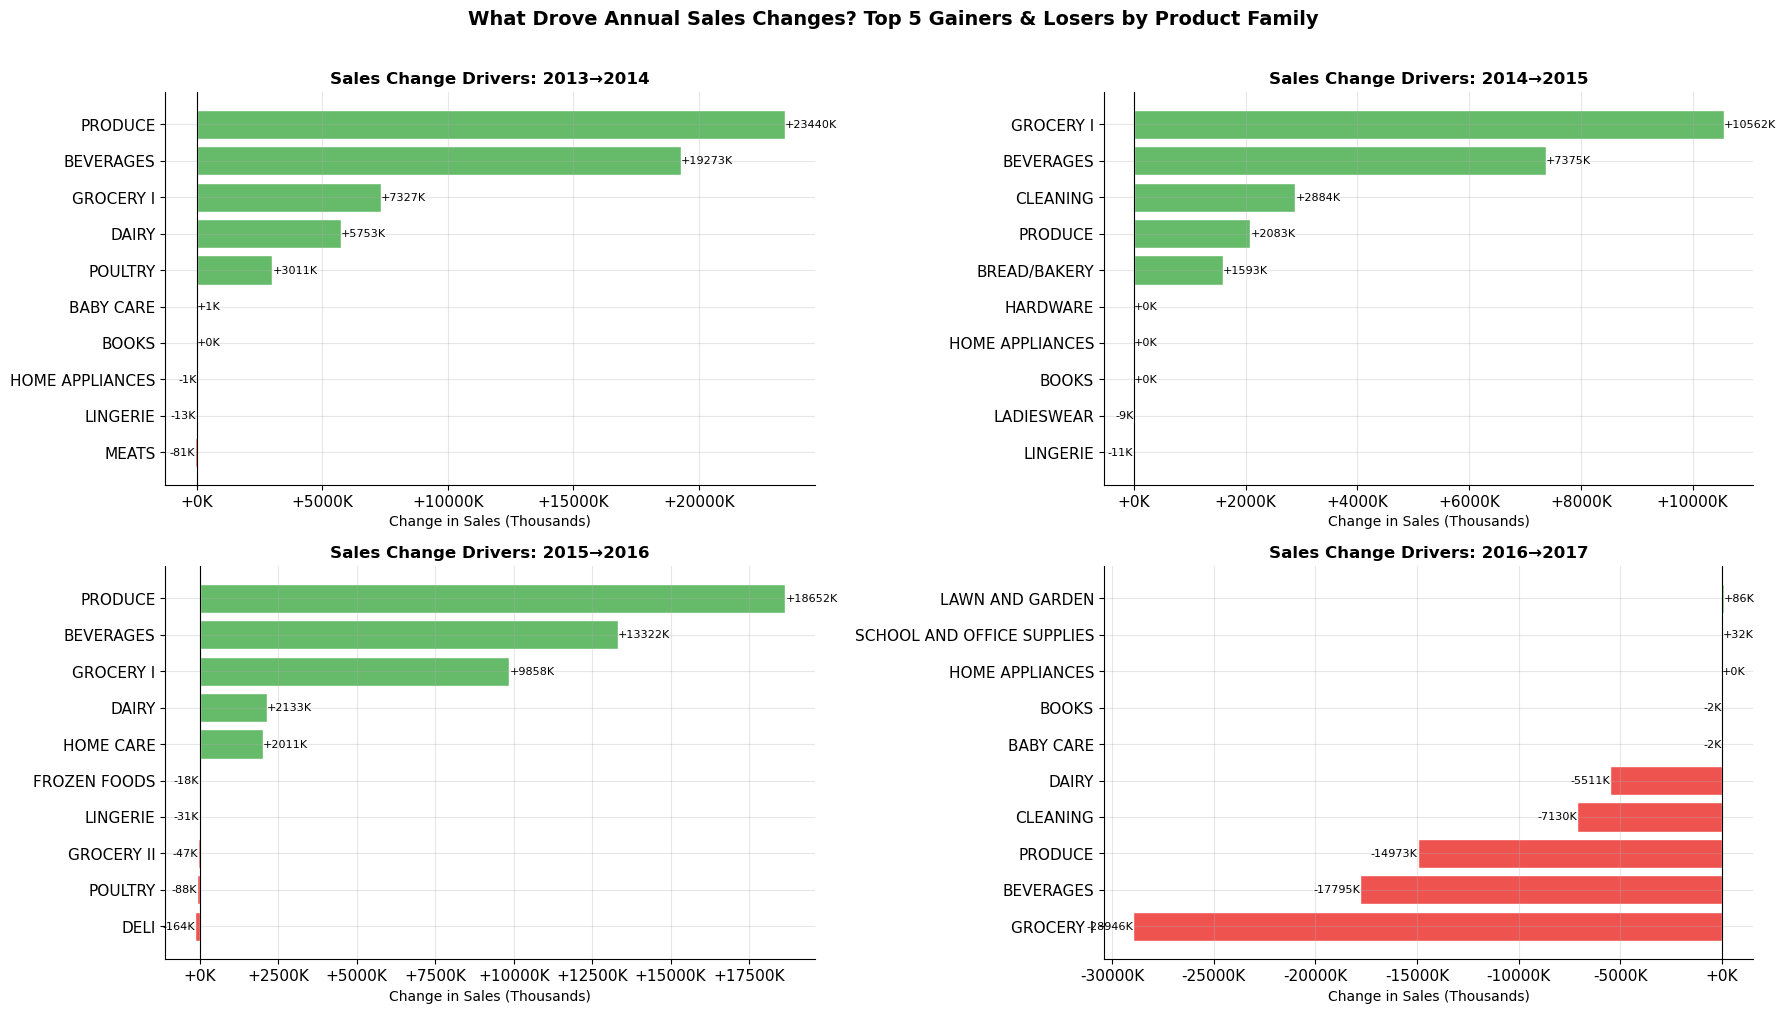

   ✅ Chart 4 done

EDA COMPLETE — 4 charts generated & saved as PNGs

Top 5 Product Families by Total Sales:
family
GROCERY I    $343.5M
BEVERAGES    $217.0M
PRODUCE      $122.7M
CLEANING      $97.5M
DAIRY         $64.5M

Annual Totals & Growth:
      total_sales  yoy_growth
year                         
2013  140419013.9         NaN
2014  209474246.3        49.2
2015  240880100.7        15.0
2016  288654523.0        19.8

Peak month:     Dec
Peak day:       Sunday


In [69]:
# ============================================================
# EDA: Store Sales Analysis — STANDALONE SCRIPT
# Run: python eda_charts.py
# Requires: pip install pandas numpy matplotlib seaborn statsmodels
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
import os, sys
import warnings
warnings.filterwarnings('ignore')

def load_data(data_dir="./data", root_dir="."):
    data_dir = Path(data_dir)
    root_dir = Path(root_dir)

    def find(filename):
        # Check data_dir first, then root
        for d in [data_dir, root_dir]:
            p = d / filename
            if p.exists():
                return p
        raise FileNotFoundError(f"❌ Could not find {filename} in {data_dir} or {root_dir}")

    print("Loading data files...")
    train  = pd.read_csv(find("train.csv"),           parse_dates=["date"])
    test   = pd.read_csv(find("test.csv"),            parse_dates=["date"])
    stores = pd.read_csv(find("stores.csv"))
    oil    = pd.read_csv(find("oil.csv"),             parse_dates=["date"])
    hol    = pd.read_csv(find("holidays_events.csv"), parse_dates=["date"])
    print(f"  Train: {train.shape}  |  Test: {test.shape}")
    print(f"  Date range: {train['date'].min().date()} → {train['date'].max().date()}")
    print(f"  Stores: {train['store_nbr'].nunique()}  |  Families: {train['family'].nunique()}")
    return train, test, stores, oil, hol

# ── Jupyter display ──────────────────────────────────────────
%matplotlib inline

# ── Style ────────────────────────────────────────────────────
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_palette("tab10")

# ── Load Data ────────────────────────────────────────────────
train, test, stores, oil, hol = load_data(data_dir="./data", root_dir=".")
train['year']      = train['date'].dt.year
train['month']     = train['date'].dt.month
train['dayofweek'] = train['date'].dt.day_name()

# Pre-aggregate daily totals once — speeds up all subsequent charts
daily = train.groupby(['date','year','month','dayofweek'])['sales'].sum().reset_index()
print(f"   Rows: {len(train):,} | Date range: {train['date'].min().date()} → {train['date'].max().date()}")

# ============================================================
# CHART 1: TOTAL ANNUAL SALES + YoY GROWTH
# ============================================================
print("\n📊 Generating Chart 1: Annual Sales...")

# Exclude 2017 — partial year (data only through Aug 2017), would distort YoY
annual = (train[train['year'] < 2017]
          .groupby('year')['sales'].sum().reset_index())
annual.columns = ['year', 'total_sales']
annual['yoy_growth'] = annual['total_sales'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_colors = sns.color_palette("Blues_d", len(annual))
bars = ax1.bar(annual['year'], annual['total_sales'] / 1e6,
               color=bar_colors, edgecolor='white', width=0.6, zorder=3)
ax1.set_ylabel('Total Sales (Millions)', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_title('Total Annual Sales & Year-over-Year Growth (2013–2017)',
               fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.0f}M'))

for bar, (_, row) in zip(bars, annual.iterrows()):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.5,
             f'${row.total_sales/1e6:.0f}M',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

ax2 = ax1.twinx()
valid = annual.dropna(subset=['yoy_growth'])
ax2.plot(valid['year'], valid['yoy_growth'], 'o--',
         color='#FF5722', lw=2, ms=8, label='YoY Growth %', zorder=4)
for _, row in valid.iterrows():
    ax2.text(row.year + 0.05, row.yoy_growth + 0.3,
             f"{row.yoy_growth:.1f}%", color='#FF5722',
             fontsize=10, fontweight='bold')
ax2.set_ylabel('YoY Growth (%)', fontsize=12, color='#FF5722')
ax2.tick_params(axis='y', colors='#FF5722')
ax2.axhline(0, color='#FF5722', linestyle=':', alpha=0.4)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.savefig('chart1_annual_sales.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Chart 1 done")

# ============================================================
# CHART 2: SEASONALITY — Monthly & Day-of-Week
# ============================================================
print("📊 Generating Chart 2: Seasonality...")

month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
monthly = train.groupby('month')['sales'].mean().reset_index()
monthly['month_name'] = month_names

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow = train.groupby('dayofweek')['sales'].mean().reindex(dow_order).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly
axes[0].bar(monthly['month_name'], monthly['sales'] / 1e6,
            color=sns.color_palette("Blues_d", 12), edgecolor='white')
axes[0].set_title('Average Daily Sales by Month', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Avg Daily Sales ($M)', fontsize=11)
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.1f}M'))
for i, row in monthly.iterrows():
    axes[0].text(i, row.sales/1e6 + 0.01, f'${row.sales/1e6:.1f}M',
                 ha='center', va='bottom', fontsize=8)

# Day of week
colors = ['#EF5350' if d == 'Sunday' else '#90CAF9' for d in dow['dayofweek']]
axes[1].bar(dow['dayofweek'], dow['sales'] / 1e3,
            color=colors, edgecolor='white')
axes[1].set_title('Average Daily Sales by Day of Week', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Avg Daily Sales ($K)', fontsize=11)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:.0f}K'))
axes[1].tick_params(axis='x', rotation=30)
for i, row in dow.iterrows():
    axes[1].text(i, row.sales/1e3 + 0.3, f'${row.sales/1e3:.0f}K',
                 ha='center', va='bottom', fontsize=8)

plt.suptitle('Seasonality Patterns in Store Sales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('chart2_seasonality.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Chart 2 done")

# ============================================================
# CHART 3: PRODUCT FAMILY SHARE BY YEAR
# ============================================================
print("📊 Generating Chart 3: Product Family Share...")

pfam_annual = train.groupby(['year','family'])['sales'].sum().reset_index()
year_totals  = pfam_annual.groupby('year')['sales'].transform('sum')
pfam_annual['share'] = pfam_annual['sales'] / year_totals * 100

top10 = (pfam_annual.groupby('family')['sales'].sum()
         .nlargest(10).index.tolist())
pfam_annual['family_grp'] = pfam_annual['family'].apply(
    lambda x: x if x in top10 else 'OTHER')
pfam_plot = (pfam_annual.groupby(['year','family_grp'])['share']
             .sum().unstack().fillna(0))

fig, ax = plt.subplots(figsize=(14, 7))
pfam_plot.plot(kind='bar', stacked=True, ax=ax,
               colormap='tab20', edgecolor='white', width=0.6)
ax.set_title('Product Family Share of Total Sales by Year',
              fontsize=14, fontweight='bold')
ax.set_ylabel('Share of Annual Sales (%)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.legend(title='Product Family', bbox_to_anchor=(1.01,1),
          loc='upper left', fontsize=9)

for year_idx, year in enumerate(pfam_plot.index):
    cumulative = 0
    for col in pfam_plot.columns:
        val = pfam_plot.loc[year, col]
        if val > 8:
            ax.text(year_idx, cumulative + val/2, f'{val:.0f}%',
                    ha='center', va='center', fontsize=8,
                    fontweight='bold', color='white')
        cumulative += val

plt.tight_layout()
plt.savefig('chart3_pfam_share.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Chart 3 done")

# ============================================================
# CHART 4: YoY SALES DRIVERS BY PRODUCT FAMILY
# ============================================================
print("📊 Generating Chart 4: YoY Drivers...")

years = sorted(train['year'].unique())
driver_rows = []
for i in range(1, len(years)):
    yr_prev, yr_curr = years[i-1], years[i]
    prev = train[train['year']==yr_prev].groupby('family')['sales'].sum()
    curr = train[train['year']==yr_curr].groupby('family')['sales'].sum()
    diff = (curr - prev).fillna(0).reset_index()
    diff.columns = ['family', 'change']
    diff['year_pair'] = f'{yr_prev}→{yr_curr}'
    driver_rows.append(diff)
drivers = pd.concat(driver_rows)

year_pairs = drivers['year_pair'].unique()
n = len(year_pairs)
cols = 2
rows = (n + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

for idx, yp in enumerate(year_pairs):
    subset = drivers[drivers['year_pair']==yp]
    top5_gain = subset.nlargest(5, 'change')
    top5_loss = subset.nsmallest(5, 'change')
    plot_data = pd.concat([top5_loss, top5_gain]).sort_values('change')

    colors = ['#EF5350' if x < 0 else '#66BB6A' for x in plot_data['change']]
    axes[idx].barh(plot_data['family'], plot_data['change']/1e3,
                   color=colors, edgecolor='white')
    axes[idx].axvline(0, color='black', lw=0.8)
    axes[idx].set_title(f'Sales Change Drivers: {yp}',
                         fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Change in Sales (Thousands)', fontsize=10)
    axes[idx].xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'{x:+.0f}K'))
    for _, row in plot_data.iterrows():
        offset = 2 if row['change'] >= 0 else -2
        ha = 'left' if row['change'] >= 0 else 'right'
        axes[idx].text(row['change']/1e3 + offset, row['family'],
                       f"{row['change']/1e3:+.0f}K",
                       va='center', ha=ha, fontsize=8)

# Hide unused subplots
for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('What Drove Annual Sales Changes? Top 5 Gainers & Losers by Product Family',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('chart4_yoy_drivers.png', dpi=150, bbox_inches='tight')
plt.show()
print("   ✅ Chart 4 done")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("EDA COMPLETE — 4 charts generated & saved as PNGs")
print("="*60)
print(f"\nTop 5 Product Families by Total Sales:")
print(train.groupby('family')['sales'].sum().nlargest(5)
      .apply(lambda x: f'${x/1e6:.1f}M').to_string())
print(f"\nAnnual Totals & Growth:")
print(annual.set_index('year').round(1).to_string())
print(f"\nPeak month:     {month_names[monthly['sales'].idxmax()]}")
print(f"Peak day:       {dow.loc[dow['sales'].idxmax(), 'dayofweek']}")